<a href="https://colab.research.google.com/github/Asswinr/Airline-Passenger-Satisfaction--Qlik-Analysis/blob/main/Price_forecasting_specific_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from math import sqrt

In [ ]:
# Read the datasets

df_weather = pd.read_csv('/content/weather_features_1.csv')

df_energy = pd.read_csv('/content/energy_dataset_1.csv')

In [ ]:
# Drop unusable columns

df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale',
                            'generation fossil peat', 'generation geothermal',
                            'generation hydro pumped storage aggregated', 'generation marine',
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'forecast wind onshore day ahead'],
                            axis=1)

In [ ]:
df_energy.describe().round(2)


,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.00,35046.00,35046.00,35046.00,35045.00,35045.00,35045.00,35046.00,35047.00,35046.00,35046.00,35046.00,35045.00,35046.00,35064.00,35064.00,35028.00,35064.00,35064.00
mean,383.51,448.06,5622.74,4256.07,298.32,475.58,972.12,2605.11,6263.91,60.23,85.64,1432.67,269.45,5464.48,1439.07,28712.13,28696.94,49.87,57.88
std,85.35,354.57,2201.83,1961.60,52.52,792.41,400.78,1835.20,839.67,20.24,14.08,1680.12,50.20,3213.69,1677.70,4594.10,4574.99,14.62,14.20
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18105.00,18041.00,2.06,9.33
25%,333.00,0.00,4126.00,2527.00,263.00,0.00,637.00,1077.25,5760.00,53.00,73.00,71.00,240.00,2933.00,69.00,24793.75,24807.75,41.49,49.35
50%,367.00,509.00,4969.00,4474.00,300.00,68.00,906.00,2164.00,6566.00,57.00,88.00,616.00,279.00,4849.00,576.00,28906.00,28901.00,50.52,58.02
75%,433.00,757.00,6429.00,5838.75,330.00,616.00,1250.00,3757.00,7025.00,80.00,97.00,2578.00,310.00,7398.00,2636.00,32263.25,32192.00,60.53,68.01
max,592.00,999.00,20034.00,8359.00,449.00,4523.00,2000.00,9728.00,7117.00,106.00,119.00,5792.00,357.00,17436.00,5836.00,41390.00,41015.00,101.99,116.80


In [ ]:
df_energy.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 20 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

In [ ]:
# Convert time to datetime object and set it as index

df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
df_energy = df_energy.set_index('time')

<ipython-input-8-05dcf7f00c1c>:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)


In [ ]:
# Find NaNs and duplicates in df_energy

print('There are {} missing values or NaNs in df_energy.'
      .format(df_energy.isnull().values.sum()))

temp_energy = df_energy.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_energy based on all columns.'
      .format(temp_energy))

There are 292 missing values or NaNs in df_energy.
There are 0 duplicate rows in df_energy based on all columns.


In [ ]:
df_energy.isnull().sum(axis=0)


generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
forecast solar day ahead                        0
total load forecast                             0
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

In [ ]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None):

    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

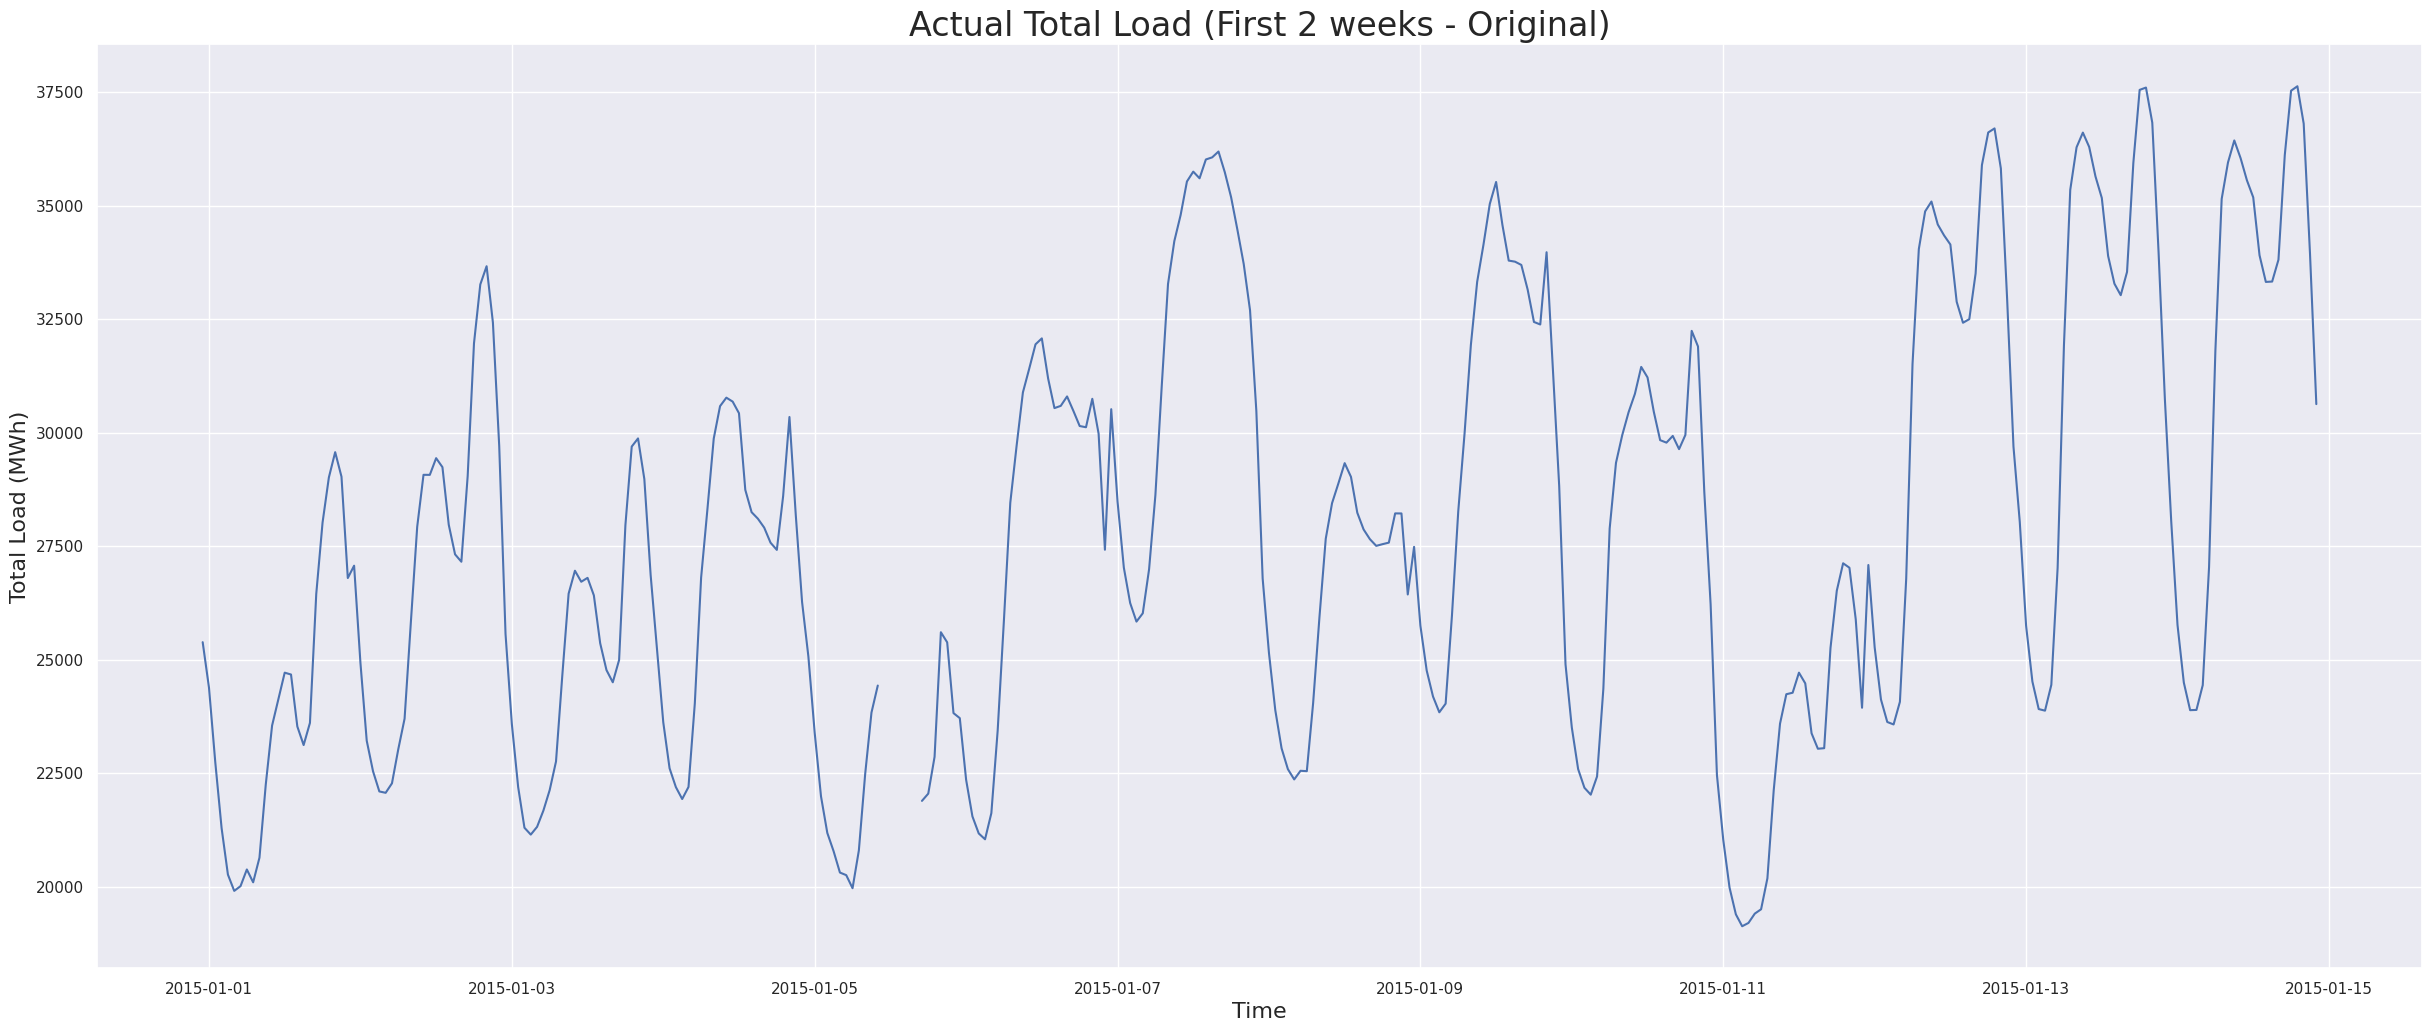

In [ ]:
#Zoom into the plot of the hourly (actual) total load

ax = plot_series(df=df_energy, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Original)', end=24*7*2)
plt.show()

In [ ]:
# Display the rows with null values

df_energy[df_energy.isnull().any(axis=1)].tail()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,
2016-11-23 03:00:00+00:00,NaN,900.0,4838.0,4547.0,269.0,1413.0,795.0,435.0,5040.0,60.0,85.0,15.0,227.0,4598.0,3,23469,23112.0,43.19,49.11
2017-11-14 11:00:00+00:00,0.0,0.0,10064.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4325,33805,NaN,60.53,66.17
2017-11-14 18:00:00+00:00,0.0,0.0,12336.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128,35592,NaN,68.05,75.45
2018-06-11 16:00:00+00:00,331.0,506.0,7538.0,5360.0,300.0,1.0,1134.0,4258.0,5856.0,52.0,96.0,170.0,269.0,9165.0,125,34752,NaN,69.87,64.93
2018-07-11 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,849,33938,NaN,63.01,69.79


In [ ]:
# Fill null values

df_energy.fillna(method='ffill', inplace=True)


In [ ]:
df_energy

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,17,26118,25385.0,50.10,65.41
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,16,24934,24382.0,48.10,64.92
2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,8,23515,22734.0,47.33,64.48
2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,2,22642,21286.0,42.27,59.32
2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,9,21785,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,63.0,95.0,85.0,277.0,3113.0,96,30619,30653.0,68.85,77.02
2018-12-31 19:00:00+00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,62.0,95.0,33.0,280.0,3288.0,51,29932,29735.0,68.40,76.16
2018-12-31 20:00:00+00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,61.0,94.0,31.0,286.0,3503.0,36,27903,28071.0,66.88,74.30


In [ ]:
df_energy.reset_index(inplace=True)

# Reorder columns to ensure 'time' is the first column
df_energy = df_energy[['time'] + [col for col in df_energy.columns if col != 'time']]

# Now you can save it to a CSV file
df_energy.to_csv('energy_with_time_cleaned.csv', index=False)

In [ ]:
# Display the number of non-zero values in each column

print('Non-zero values in each column:\n', df_energy.astype(bool).sum(axis=0), sep='\n')

Non-zero values in each column:

time                                           35064
generation biomass                             35060
generation fossil brown coal/lignite           24540
generation fossil gas                          35063
generation fossil hard coal                    35061
generation fossil oil                          35061
generation hydro pumped storage consumption    22449
generation hydro run-of-river and poundage     35061
generation hydro water reservoir               35061
generation nuclear                             35061
generation other                               35060
generation other renewable                     35061
generation solar                               35061
generation waste                               35061
generation wind onshore                        35061
forecast solar day ahead                       34525
total load forecast                            35064
total load actual                              35064
price day ahe

In [ ]:
df_weather.head()


,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [ ]:
df_weather.describe().round(2)


,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00,178396.00
mean,289.62,288.33,291.09,1069.26,68.42,2.47,166.59,0.08,0.00,0.00,25.07,759.83
std,8.03,7.96,8.61,5969.63,21.90,2.10,116.61,0.40,0.01,0.22,30.77,108.73
min,262.24,262.24,262.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,200.00
25%,283.67,282.48,284.65,1013.00,53.00,1.00,55.00,0.00,0.00,0.00,0.00,800.00
50%,289.15,288.15,290.15,1018.00,72.00,2.00,177.00,0.00,0.00,0.00,20.00,800.00
75%,295.15,293.73,297.15,1022.00,87.00,4.00,270.00,0.00,0.00,0.00,40.00,801.00
max,315.60,315.15,321.15,1008371.00,100.00,133.00,360.00,12.00,2.32,21.50,100.00,804.00


In [ ]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

In [ ]:

# Convert columns with int64 type values to float64 type

df_weather = df_convert_dtypes(df_weather, np.int64, np.float64)

In [ ]:
# Convert dt_iso to datetime type, rename it and set it as index

df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather = df_weather.set_index('time')

<ipython-input-20-4a930e75b420>:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)


In [ ]:
# Find NaNs and duplicates in df_weather

print('There are {} missing values or NaNs in df_weather.'
      .format(df_weather.isnull().values.sum()))

temp_weather = df_weather.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_weather based on all columns.'
      .format(temp_weather))

There are 0 missing values or NaNs in df_weather.
There are 8622 duplicate rows in df_weather based on all columns.


In [ ]:
# Display the number of rows in each dataframe

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

cities = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]),
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35145 observations in df_weather about city: Valencia.
There are 36267 observations in df_weather about city: Madrid.
There are 35951 observations in df_weather about city: Bilbao.
There are 35476 observations in df_weather about city:  Barcelona.
There are 35557 observations in df_weather about city: Seville.


In [ ]:
# Create df_weather_2 and drop duplicate rows in df_weather

df_weather_2 = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                        keep='last').set_index('time')

df_weather = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                      keep='first').set_index('time')

In [ ]:
# Display the number of rows in each dataframe again

print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]),
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
There are 35064 observations in df_weather about city: Valencia.
There are 35064 observations in df_weather about city: Madrid.
There are 35064 observations in df_weather about city: Bilbao.
There are 35064 observations in df_weather about city:  Barcelona.
There are 35064 observations in df_weather about city: Seville.


In [ ]:
# Display all the unique values in the column 'weather_description'

weather_description_unique = df_weather['weather_description'].unique()
weather_description_unique

array(['sky is clear', 'few clouds', 'scattered clouds', 'broken clouds',
       'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'mist', 'heavy intensity shower rain',
       'shower rain', 'very heavy rain', 'thunderstorm with heavy rain',
       'thunderstorm with light rain', 'proximity thunderstorm',
       'thunderstorm', 'light intensity shower rain',
       'light intensity drizzle', 'thunderstorm with rain', 'fog',
       'smoke', 'drizzle', 'heavy intensity drizzle', 'haze',
       'proximity shower rain', 'light snow', 'rain and snow',
       'light rain and snow', 'snow', 'sleet', 'rain and drizzle',
       'light intensity drizzle rain', 'light shower snow',
       'proximity moderate rain', 'ragged shower rain', 'heavy snow',
       'sand dust whirls', 'proximity drizzle', 'dust',
       'light thunderstorm', 'squalls'], dtype=object)

In [ ]:
# Display all the unique values in the column 'weather_main'

weather_main_unique = df_weather['weather_main'].unique()
weather_main_unique

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [ ]:
# Display all the unique values in the column 'weather_id'

weather_id_unique = df_weather['weather_id'].unique()
weather_id_unique

array([800., 801., 802., 803., 804., 500., 501., 502., 701., 522., 521.,
       503., 202., 200., 211., 520., 300., 201., 741., 711., 301., 302.,
       721., 600., 616., 615., 601., 611., 311., 310., 620., 531., 602.,
       731., 761., 210., 771.])

In [ ]:
# Define a function which will calculate R-squared score for the same column in two dataframes

def encode_and_display_r2_score(df_1, df_2, column, categorical=False):
    dfs = [df_1, df_2]
    if categorical:
        for df in dfs:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
    r2 = r2_score(df_1[column], df_2[column])
    print("R-Squared score of {} is {}".format(column, r2.round(3)))

In [ ]:
# Display the R-squared scores for the columns with qualitative weather descriptions in df_weather and df_weather_2

encode_and_display_r2_score(df_weather, df_weather_2, 'weather_description', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_main', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_id')

R-Squared score of weather_description is 0.973
R-Squared score of weather_main is 0.963
R-Squared score of weather_id is 0.921


In [ ]:
# Drop columns with qualitative weather information
df_weather = df_weather.drop(['weather_main', 'weather_id',
                              'weather_description', 'weather_icon'], axis=1)

In [ ]:
df_weather.drop(['rain_3h'], axis = 1 , inplace = True)


In [ ]:
# Assuming df_weather has 'time' as its index
df_weather.reset_index(inplace=True)

# Reorder columns to ensure 'time' is the first column
df_weather = df_weather[['time'] + [col for col in df_weather.columns if col != 'time']]

# Now you can save it to a CSV file
df_weather.to_csv('Weather_with_time_column.csv', index=False)


In [ ]:
df_weather

,time,index,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all
0,2014-12-31 23:00:00+00:00,0,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0
1,2015-01-01 00:00:00+00:00,1,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0
2,2015-01-01 01:00:00+00:00,2,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0
3,2015-01-01 02:00:00+00:00,3,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0
4,2015-01-01 03:00:00+00:00,4,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
175315,2018-12-31 18:00:00+00:00,175315,287.760,287.150,288.150,1028.0,54.0,3.0,30.0,0.0,0.0,0.0
175316,2018-12-31 19:00:00+00:00,175316,285.760,285.150,286.150,1029.0,62.0,3.0,30.0,0.0,0.0,0.0
175317,2018-12-31 20:00:00+00:00,175317,285.150,285.150,285.150,1028.0,58.0,4.0,50.0,0.0,0.0,0.0
175318,2018-12-31 21:00:00+00:00,175318,284.150,284.150,284.150,1029.0,57.0,4.0,60.0,0.0,0.0,0.0


In [ ]:
df_energy

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,total load forecast,total load actual,price day ahead,price actual
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,17,26118,25385.0,50.10,65.41
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,16,24934,24382.0,48.10,64.92
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,8,23515,22734.0,47.33,64.48
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,2,22642,21286.0,42.27,59.32
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,9,21785,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 18:00:00+00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,63.0,95.0,85.0,277.0,3113.0,96,30619,30653.0,68.85,77.02
35060,2018-12-31 19:00:00+00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,62.0,95.0,33.0,280.0,3288.0,51,29932,29735.0,68.40,76.16
35061,2018-12-31 20:00:00+00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,61.0,94.0,31.0,286.0,3503.0,36,27903,28071.0,66.88,74.30
35062,2018-12-31 21:00:00+00:00,293.0,0.0,6562.0,2293.0,163.0,108.0,1128.0,2068.0,6075.0,61.0,93.0,31.0,287.0,3586.0,29,25450,25801.0,63.93,69.89


## Merging cleaned Datasets

In [ ]:

# Load the cleaned datasets
df_weather = pd.read_csv('/content/Weather_with_time_column.csv')
df_energy = pd.read_csv('/content/energy_with_time_cleaned.csv')


In [ ]:
df_weather['time'] = pd.to_datetime(df_weather['time'])
df_energy['time'] = pd.to_datetime(df_energy['time'])

In [ ]:
#df_weather = df_weather.drop(columns=['city_name'])

# Group by 'time' and take the mean for each time hour
df_weather_avg = df_weather.groupby('time').mean().reset_index()

In [ ]:
df_merged = pd.merge(df_energy, df_weather_avg, on='time', how='inner')


In [ ]:
df_merged.to_csv('Merged_weather_energy.csv', index=False)
df_merged.head()


,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,272.491463,272.491463,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,272.512700,272.512700,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,272.099137,272.099137,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,272.089469,272.089469,272.089469,1016.6,82.0,2.4,119.2,0.0,0.0,0.0
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,272.145900,272.145900,272.145900,1016.6,82.0,2.4,118.4,0.0,0.0,0.0


In [ ]:
df_merged = pd.read_csv('/content/Merged_weather_energy (3).csv')


In [ ]:
df_merged

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,272.491463,272.491463,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,272.512700,272.512700,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,272.099137,272.099137,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,272.089469,272.089469,272.089469,1016.6,82.0,2.4,119.2,0.0,0.0,0.0
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,272.145900,272.145900,272.145900,1016.6,82.0,2.4,118.4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 18:00:00+00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,...,284.470000,283.350000,285.550000,1029.2,73.6,1.4,151.4,0.0,0.0,0.0
35060,2018-12-31 19:00:00+00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,...,282.294000,280.950000,283.350000,1030.0,68.0,1.8,160.4,0.0,0.0,0.0
35061,2018-12-31 20:00:00+00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,...,280.850000,280.350000,281.350000,1029.8,71.4,2.6,226.0,0.0,0.0,0.0
35062,2018-12-31 21:00:00+00:00,293.0,0.0,6562.0,2293.0,163.0,108.0,1128.0,2068.0,6075.0,...,279.718000,278.750000,280.750000,1030.2,70.0,2.8,230.0,0.0,0.0,0.0


## Visualization

In [ ]:
def feat_corr(input_df):
    corr = input_df.corr()
    plt.figure(figsize=(15,12))
    #plot heat map
    g=sns.heatmap(corr,annot=True,cmap="RdYlGn", vmin=-1, vmax=1)
    plt.title('Feature Correlation')

    return plt.show()

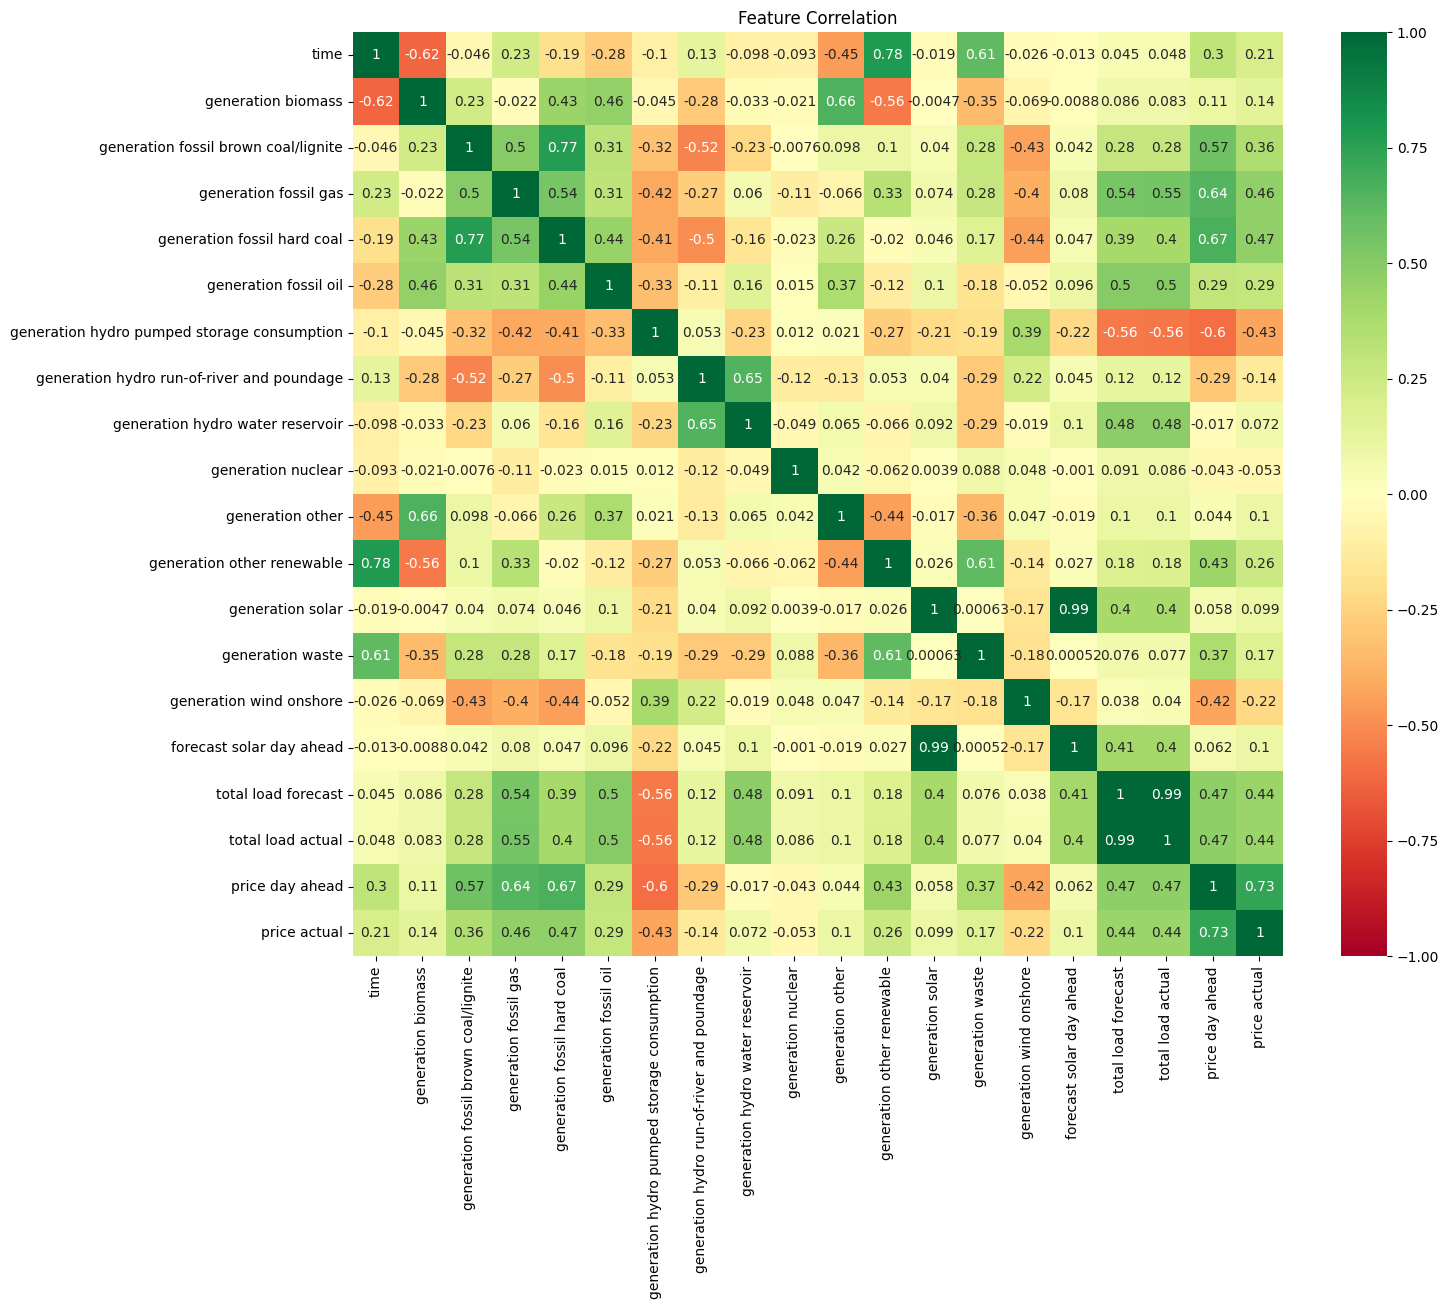

In [ ]:
feat_corr(df_energy)


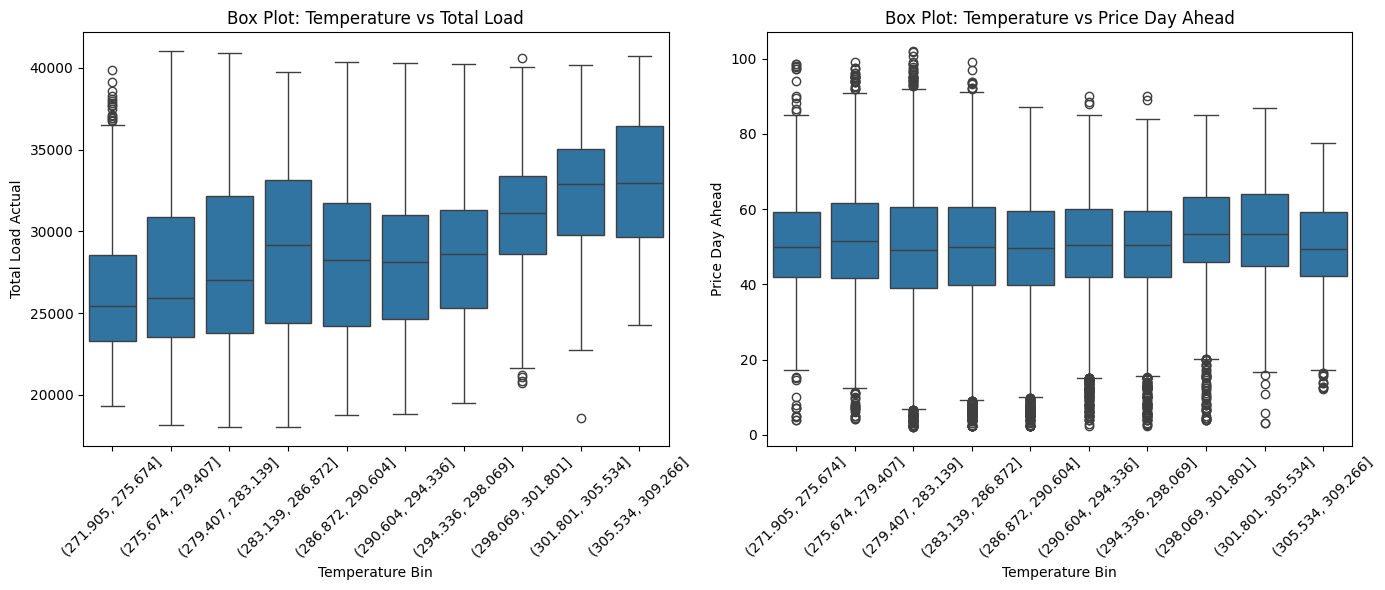

In [ ]:
plt.figure(figsize=(14, 6))

# Create bins for temperature
df_merged['temp_bin'] = pd.cut(df_merged['temp'], bins=10)

# Box plot for Temperature vs Total Load
plt.subplot(1, 2, 1)
sns.boxplot(x='temp_bin', y='total load actual', data=df_merged)
plt.xticks(rotation=45)
plt.xlabel('Temperature Bin')
plt.ylabel('Total Load Actual')
plt.title('Box Plot: Temperature vs Total Load')

# Box plot for Temperature vs Price
plt.subplot(1, 2, 2)
sns.boxplot(x='temp_bin', y='price day ahead', data=df_merged)
plt.xticks(rotation=45)
plt.xlabel('Temperature Bin')
plt.ylabel('Price Day Ahead')
plt.title('Box Plot: Temperature vs Price Day Ahead')

plt.tight_layout()
plt.show()



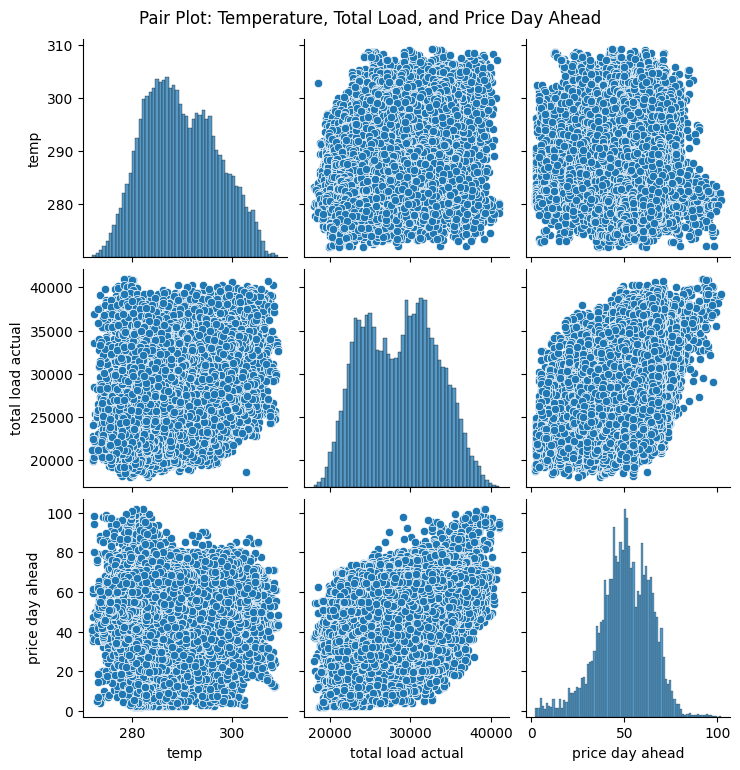

In [ ]:
sns.pairplot(df_merged[['temp', 'total load actual', 'price day ahead']])
plt.suptitle('Pair Plot: Temperature, Total Load, and Price Day Ahead', y=1.02)
plt.show()


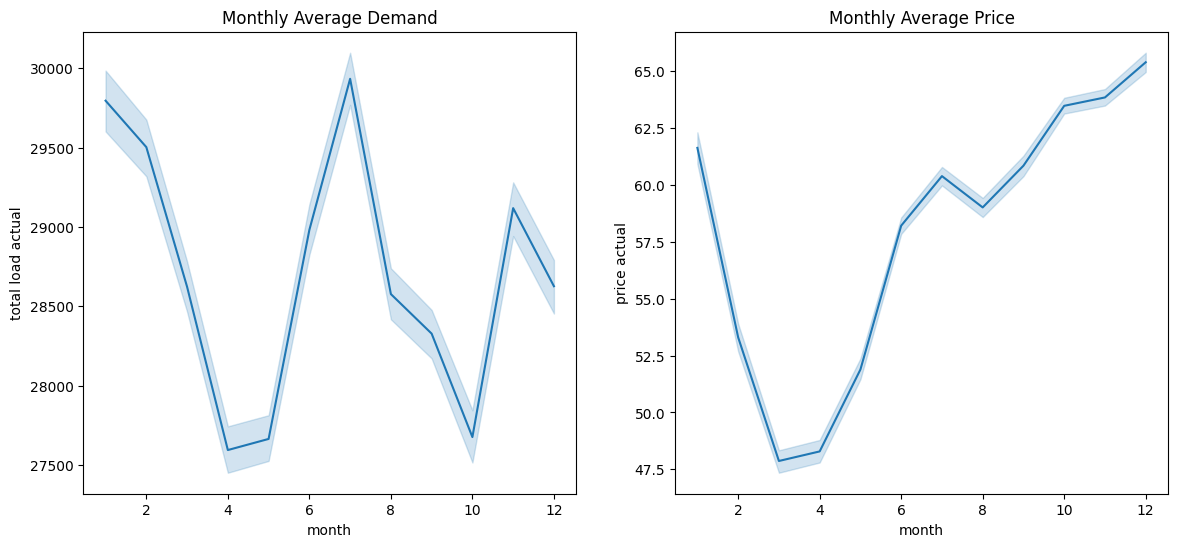

In [ ]:
# Extract month from the time column
df_merged['time'] = pd.to_datetime(df_merged['time'])

df_merged['month'] = df_merged['time'].dt.month

# Line plot for monthly demand
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(x='month', y='total load actual', data=df_merged, estimator='mean')
plt.title('Monthly Average Demand')

# Line plot for monthly price
plt.subplot(1, 2, 2)
sns.lineplot(x='month', y='price actual', data=df_merged, estimator='mean')
plt.title('Monthly Average Price')
plt.show()


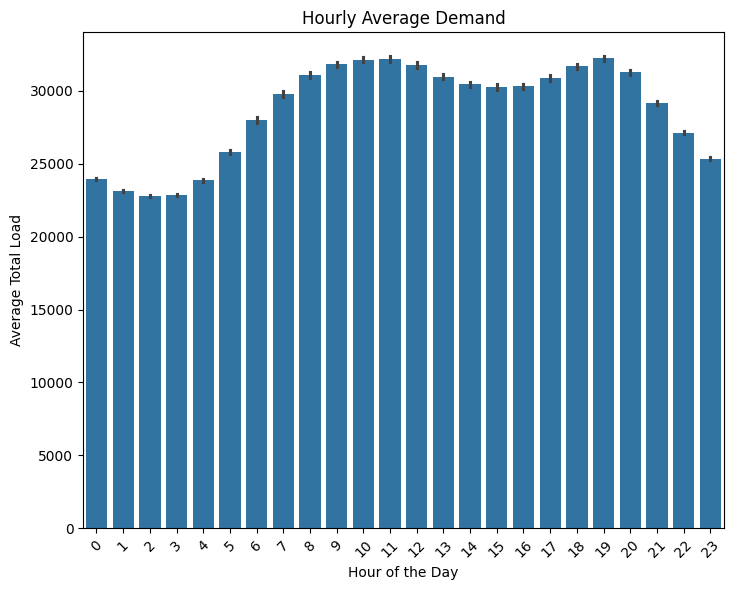

In [ ]:
df_merged['hour'] = df_merged['time'].dt.hour

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='hour', y='total load actual', data=df_merged, estimator='mean')  # Change lineplot to barplot
plt.title('Hourly Average Demand')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Total Load')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust spacing between subplots and elements
plt.show()

The above plot shows the Avergae total load by day ahed we can see the load is high during the business hours throuhghout the day and low during night and non business hours

<ipython-input-9-5802548326c8>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='total load actual', data=avg_demand_by_month, palette="viridis")


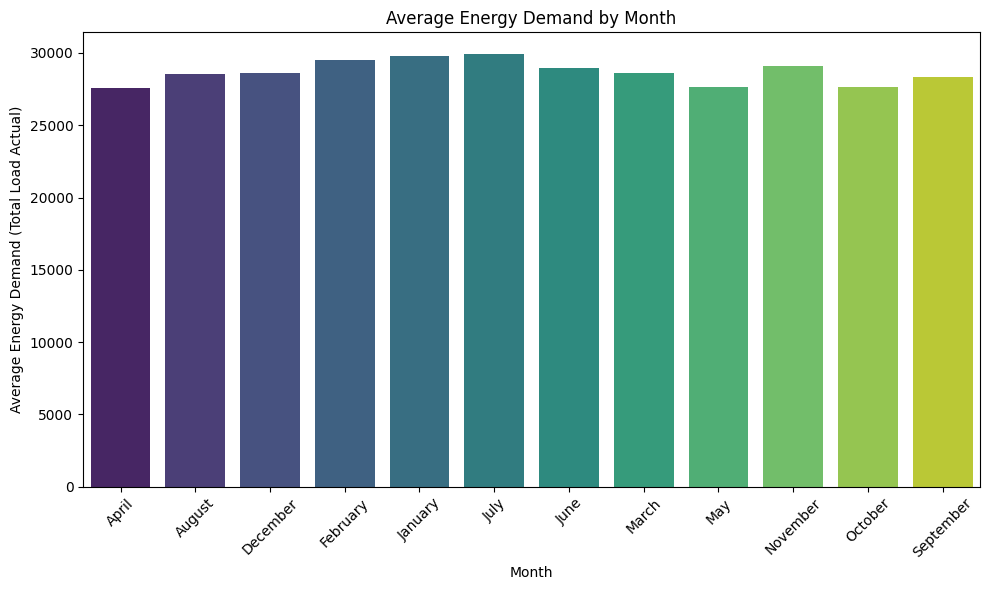

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'time' column is in datetime format
df_merged['time'] = pd.to_datetime(df_merged['time'])

# Extract month name from 'time' column
df_merged['month'] = df_merged['time'].dt.month_name()

# Calculate average energy demand (total load actual) by month
avg_demand_by_month = df_merged.groupby('month')['total load actual'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='total load actual', data=avg_demand_by_month, palette="viridis")
plt.title('Average Energy Demand by Month')
plt.xlabel('Month')
plt.ylabel('Average Energy Demand (Total Load Actual)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


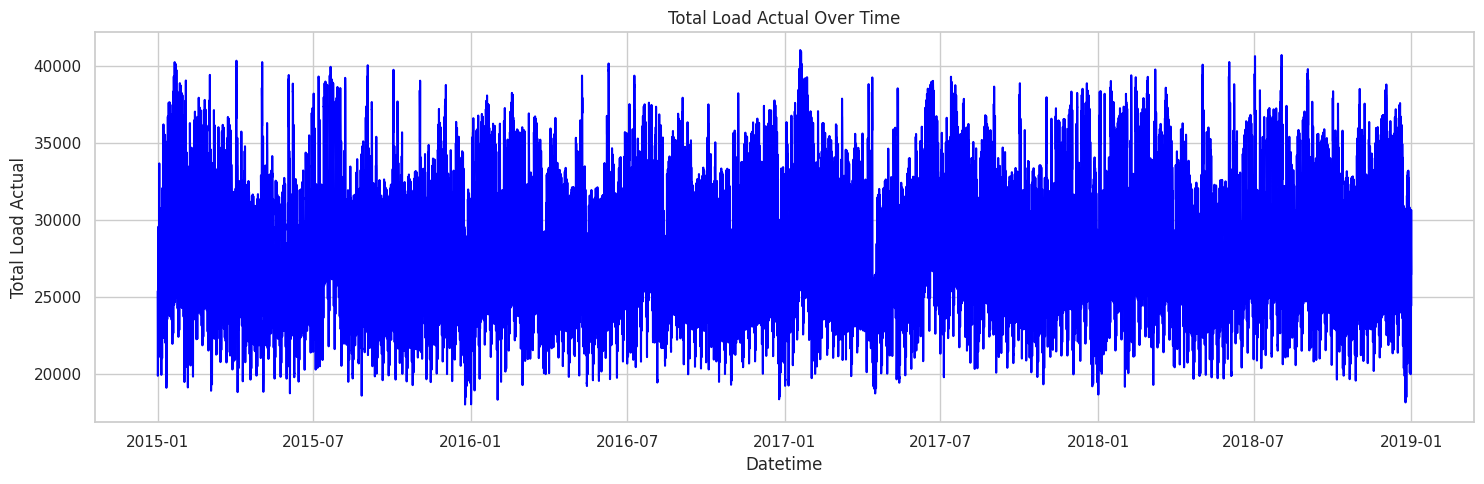

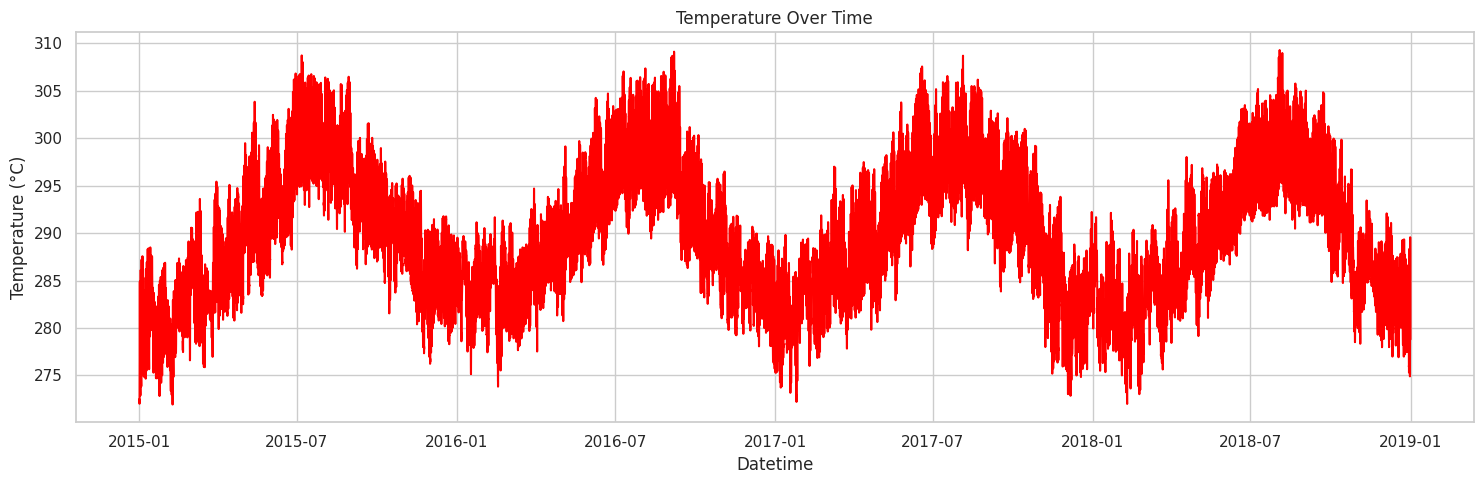

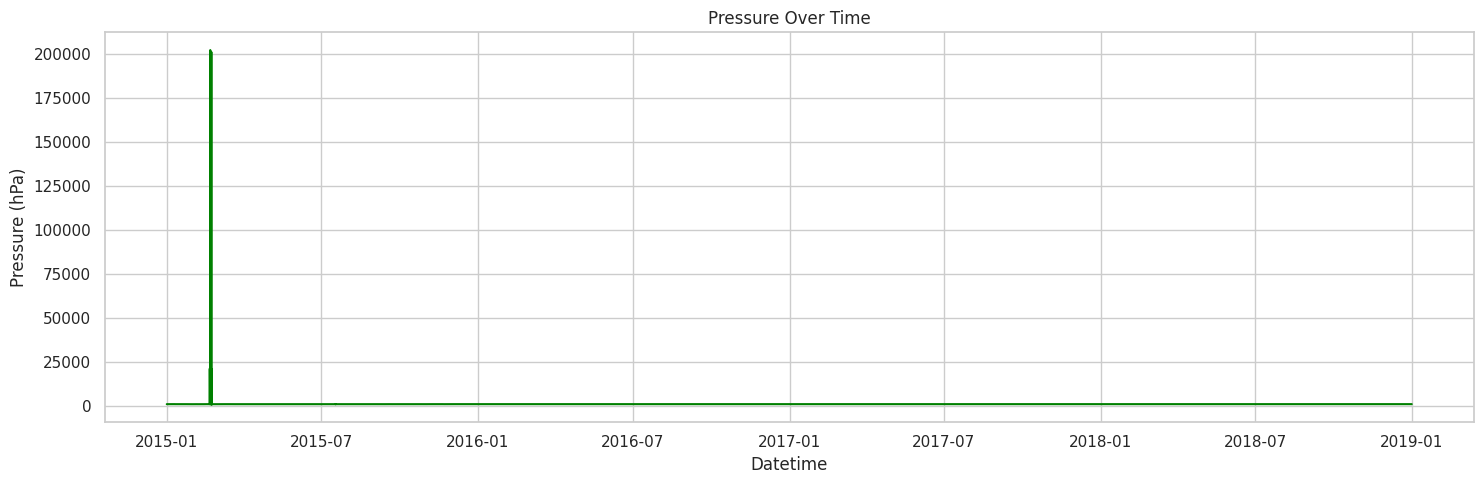

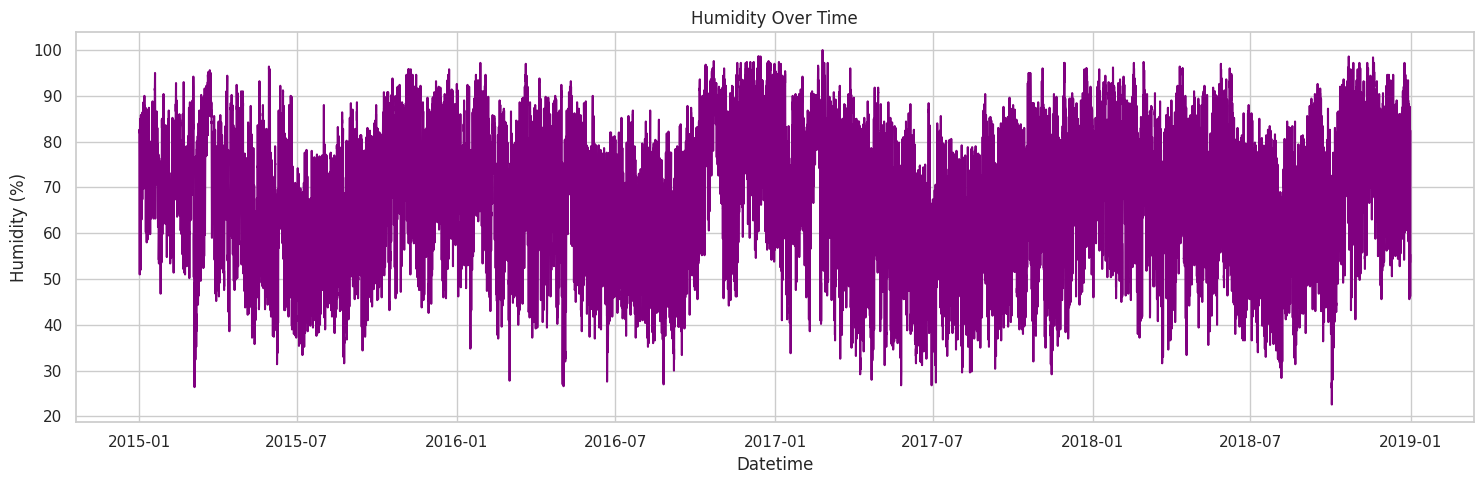

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot Total Load Actual over Time
plt.figure(figsize=(15, 5))
sns.lineplot(x='time', y='total load actual', data=df_merged, color='blue')
plt.title('Total Load Actual Over Time')
plt.ylabel('Total Load Actual')
plt.xlabel('Datetime')
plt.tight_layout()
plt.show()

# Plot Temperature over Time
plt.figure(figsize=(15, 5))
sns.lineplot(x='time', y='temp', data=df_merged, color='red')
plt.title('Temperature Over Time')
plt.ylabel('Temperature (°C)')
plt.xlabel('Datetime')
plt.tight_layout()
plt.show()

# Plot Pressure over Time
plt.figure(figsize=(15, 5))
sns.lineplot(x='time', y='pressure', data=df_merged, color='green')
plt.title('Pressure Over Time')
plt.ylabel('Pressure (hPa)')
plt.xlabel('Datetime')
plt.tight_layout()
plt.show()

# Plot Humidity over Time
plt.figure(figsize=(15, 5))
sns.lineplot(x='time', y='humidity', data=df_merged, color='purple')
plt.title('Humidity Over Time')
plt.ylabel('Humidity (%)')
plt.xlabel('Datetime')
plt.tight_layout()
plt.show()


 prediction of price actual and price day ahed

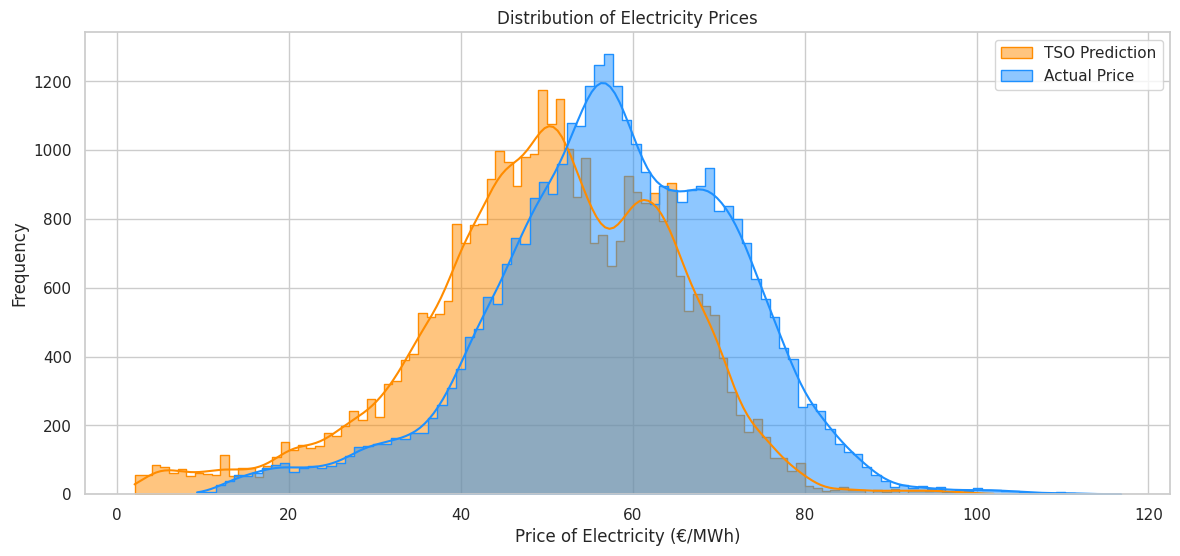

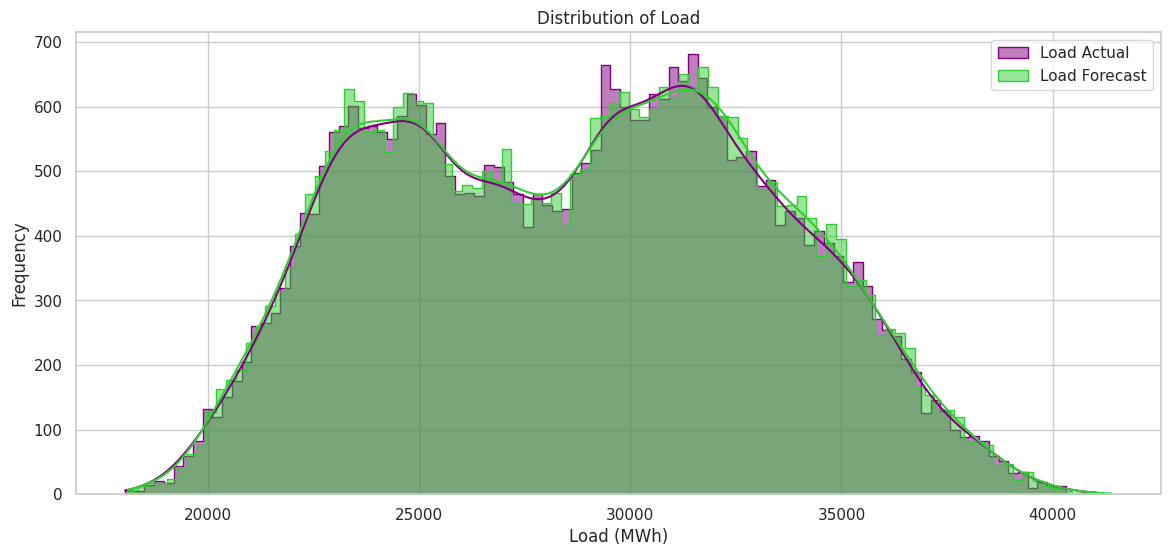

In [ ]:

sns.set(style="whitegrid")

# Price of Electricity
plt.figure(figsize=(14, 6))
gr = sns.histplot(df_merged['price day ahead'], bins=100, label='TSO Prediction', element="step", color='darkorange', kde=True)
gr = sns.histplot(df_merged['price actual'], bins=100, label='Actual Price', element="step", color='dodgerblue', kde=True)

gr.set(xlabel="Price of Electricity (€/MWh)", ylabel="Frequency")
plt.title("Distribution of Electricity Prices")
plt.legend()
plt.show()

# Load
plt.figure(figsize=(14, 6))
gr = sns.histplot(df_merged['total load actual'], bins=100, label='Load Actual', element="step", color='purple', kde=True)
gr = sns.histplot(df_merged['total load forecast'], bins=100, label='Load Forecast', element="step", color='limegreen', kde=True)

gr.set(xlabel="Load (MWh)", ylabel="Frequency")
plt.title("Distribution of Load")
plt.legend()
plt.show()


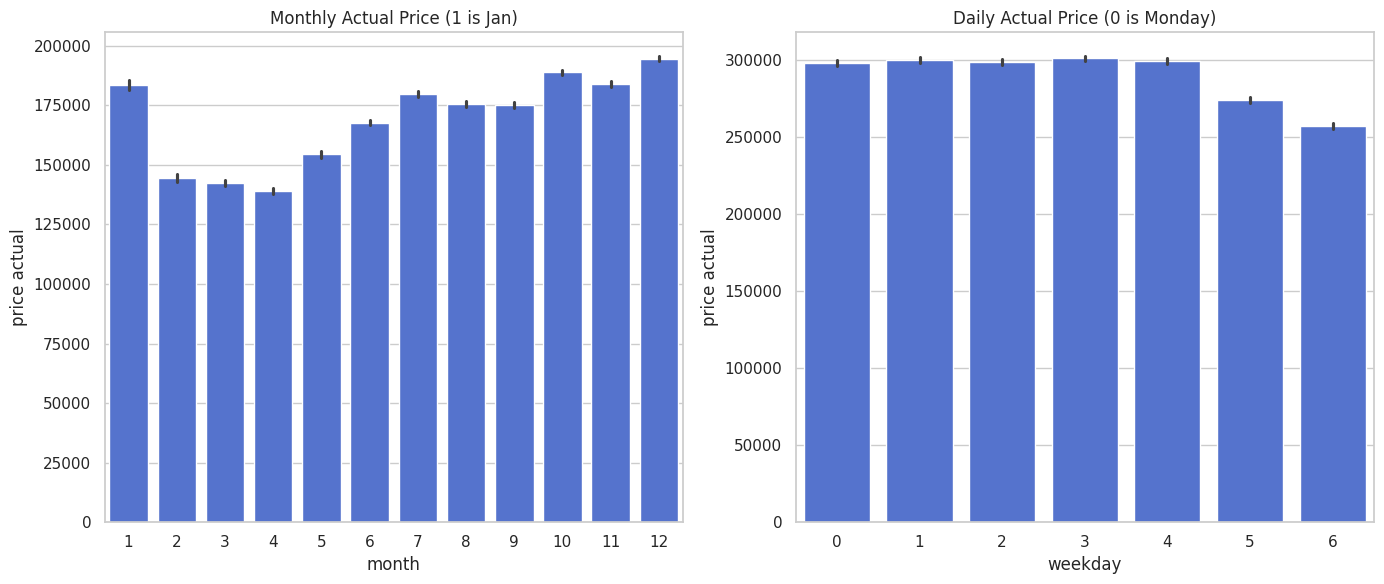

In [ ]:


# Add 'month' and 'weekday' columns
df_merged['month'] = df_merged['time'].dt.month
df_merged['weekday'] = df_merged['time'].dt.weekday

# Create subplots
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.set(style="darkgrid")

# Bar plot for Monthly actual price
sns.barplot(
    x="month",
    y="price actual",
    data=df_merged,
    estimator=sum,
    color='royalblue',
    ax=axes[0]
)
axes[0].set_title('Monthly Actual Price (1 is Jan)')

# Bar plot for Daily actual price
sns.barplot(
    x="weekday",
    y="price actual",
    data=df_merged,
    estimator=sum,
    color='royalblue',
    ax=axes[1]
)
axes[1].set_title('Daily Actual Price (0 is Monday)')

# Adjust layout
plt.tight_layout()
plt.show()


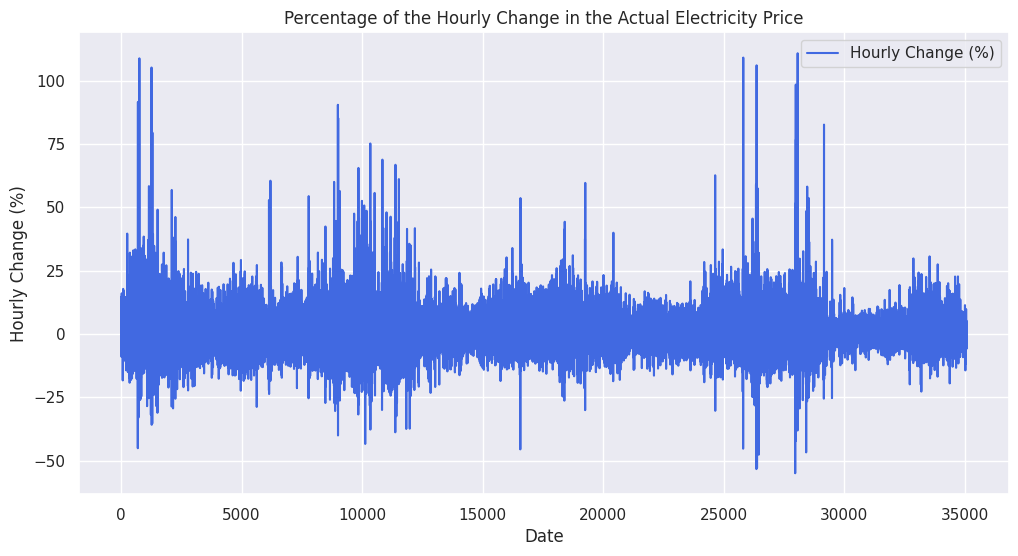

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


change = df_merged['price actual'].pct_change().mul(100)

plt.figure(figsize=(12, 6))
plt.plot(change, label='Hourly Change (%)', color='royalblue')

plt.xlabel('Date')
plt.ylabel('Hourly Change (%)')
plt.title('Percentage of the Hourly Change in the Actual Electricity Price')
plt.legend()
plt.show()


Predict based upon the price actual and price day ahed

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_absolute_error
from keras import Sequential
from keras import layers
from keras.models import Model

y_scaler_actual = MinMaxScaler()
y_scaler_dayahead = MinMaxScaler()

train_cutoff = int(0.8*df_merged.shape[0])
val_cutoff = int(0.9*df_merged.shape[0])

y_price_actual   = df_merged[['price actual']]
y_price_dayahead = df_merged[['price day ahead']]

y_scaler_actual.fit(y_price_actual[:train_cutoff])
actual_norm = y_scaler_actual.transform(y_price_actual)

y_scaler_dayahead.fit(df_merged[['price day ahead']][:train_cutoff])
dayahead_norm = y_scaler_dayahead.transform(y_price_dayahead)

print(f' mean absolute error for normalized acutal price and TSO predcition is : {round(mean_absolute_error(actual_norm, dayahead_norm),3)}')

 mean absolute error for normalized acutal price and TSO predcition is : 0.071


Here TSO stands for Transmission System Operator. In the context of energy markets, TSOs predict the day-ahead electricity prices based on various factors such as demand forecasts generation capacity, and market conditions. These predictions are crucial for planning and balancing the electricity grid.

TSO prediction output mean **absolute error between the normalized actual prices and the day-ahead prices**, which are typically predicted by TSOs.

In [ ]:
df_merged

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all,temp_bin,month,hour,weekday
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,82.4,2.0,135.2,0.0,0.0,0.0,"(271.905, 275.674]",12,23,2
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,82.4,2.0,135.8,0.0,0.0,0.0,"(271.905, 275.674]",1,0,3
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,82.0,2.4,119.0,0.0,0.0,0.0,"(271.905, 275.674]",1,1,3
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,82.0,2.4,119.2,0.0,0.0,0.0,"(271.905, 275.674]",1,2,3
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,82.0,2.4,118.4,0.0,0.0,0.0,"(271.905, 275.674]",1,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 18:00:00+00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,...,73.6,1.4,151.4,0.0,0.0,0.0,"(283.139, 286.872]",12,18,0
35060,2018-12-31 19:00:00+00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,...,68.0,1.8,160.4,0.0,0.0,0.0,"(279.407, 283.139]",12,19,0
35061,2018-12-31 20:00:00+00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,...,71.4,2.6,226.0,0.0,0.0,0.0,"(279.407, 283.139]",12,20,0
35062,2018-12-31 21:00:00+00:00,293.0,0.0,6562.0,2293.0,163.0,108.0,1128.0,2068.0,6075.0,...,70.0,2.8,230.0,0.0,0.0,0.0,"(279.407, 283.139]",12,21,0


In [ ]:
df_merged = pd.read_csv('/content/Merged_All_engineered.csv')


In [ ]:


df_merged['time'] = pd.to_datetime(df_merged['time'])

# Extract the hour from the time column
df_merged['hour'] = df_merged['time'].dt.hour

# Create 'business hour' feature using vectorized operations
df_merged['business hour'] = np.where(
    ((df_merged['hour'] > 8) & (df_merged['hour'] < 14)) | ((df_merged['hour'] > 16) & (df_merged['hour'] < 21)),
    2,
    np.where((df_merged['hour'] >= 14) & (df_merged['hour'] <= 16), 1, 0)
)

# Drop the 'hour' column if not needed
df_merged.drop(columns='hour', inplace=True)

df_merged.head()


,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all,temp_bin,month,weekday,year,business hour
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,2.0,135.2,0.0,0.0,0.0,"(271.905, 275.674]",12,2,2014,0
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,2.0,135.8,0.0,0.0,0.0,"(271.905, 275.674]",1,3,2015,0
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,2.4,119.0,0.0,0.0,0.0,"(271.905, 275.674]",1,3,2015,0
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,2.4,119.2,0.0,0.0,0.0,"(271.905, 275.674]",1,3,2015,0
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,2.4,118.4,0.0,0.0,0.0,"(271.905, 275.674]",1,3,2015,0


In [ ]:
import pandas as pd
import numpy as np

# Ensure 'time' column is in datetime format
df_merged['time'] = pd.to_datetime(df_merged['time'])

# Generate 'hour', 'weekday', 'month', and 'year' features
df_merged['hour'] = df_merged['time'].dt.hour
df_merged['weekday'] = df_merged['time'].dt.weekday
df_merged['month'] = df_merged['time'].dt.month
df_merged['year'] = df_merged['time'].dt.year

# Create 'business hour' feature using vectorized operations
df_merged['business hour'] = np.where(
    ((df_merged['hour'] > 8) & (df_merged['hour'] < 14)) | ((df_merged['hour'] > 16) & (df_merged['hour'] < 21)),
    2,
    np.where((df_merged['hour'] >= 14) & (df_merged['hour'] <= 16), 1, 0)
)

# Verify the new columns
print(df_merged.head())

# Check the number of columns
print(f"Number of columns: {len(df_merged.columns)}")
print(df_merged.columns)


                       time  generation biomass  \
0 2014-12-31 23:00:00+00:00               447.0   
1 2015-01-01 00:00:00+00:00               449.0   
2 2015-01-01 01:00:00+00:00               448.0   
3 2015-01-01 02:00:00+00:00               438.0   
4 2015-01-01 03:00:00+00:00               428.0   

   generation fossil brown coal/lignite  generation fossil gas  \
0                                 329.0                 4844.0   
1                                 328.0                 5196.0   
2                                 323.0                 4857.0   
3                                 254.0                 4314.0   
4                                 187.0                 4130.0   

   generation fossil hard coal  generation fossil oil  \
0                       4821.0                  162.0   
1                       4755.0                  158.0   
2                       4581.0                  157.0   
3                       4131.0                  160.0   
4          

In [ ]:
df_merged.drop(['total load forecast'], axis = 1, inplace = True)


In [ ]:

df_merged['time'] = pd.to_datetime(df_merged['time'])

# Generate 'weekday' feature
df_merged['weekday'] = df_merged['time'].dt.weekday

# Generate 'weekend' feature
df_merged['weekend'] = np.where(df_merged['weekday'] == 6, 2, np.where(df_merged['weekday'] == 5, 1, 0))

# Verify the new column
print(df_merged[['time', 'weekday', 'weekend']].head())


                       time  weekday  weekend
0 2014-12-31 23:00:00+00:00        2        0
1 2015-01-01 00:00:00+00:00        3        0
2 2015-01-01 01:00:00+00:00        3        0
3 2015-01-01 02:00:00+00:00        3        0
4 2015-01-01 03:00:00+00:00        3        0


In [ ]:
if 'temp_max' in df_merged.columns and 'temp_min' in df_merged.columns:
    # Generate 'temp_range' feature
    df_merged['temp_range'] = abs(df_merged['temp_max'] - df_merged['temp_min'])

    # Verify the new column
    print(df_merged[['time', 'temp_max', 'temp_min', 'temp_range']].head())
else:
    print("Columns 'temp_max' and 'temp_min' are not present in the DataFrame.")


                       time    temp_max    temp_min  temp_range
0 2014-12-31 23:00:00+00:00  272.491463  272.491463         0.0
1 2015-01-01 00:00:00+00:00  272.512700  272.512700         0.0
2 2015-01-01 01:00:00+00:00  272.099137  272.099137         0.0
3 2015-01-01 02:00:00+00:00  272.089469  272.089469         0.0
4 2015-01-01 03:00:00+00:00  272.145900  272.145900         0.0


In [ ]:
df_merged = pd.read_csv('/content/Merged_feature engineered.csv')


In [ ]:
df_merged

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,snow_3h,clouds_all,temp_bin,month,weekday,year,business hour,hour,weekend,temp_range
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,0.0,0.0,"(271.905, 275.674]",12,2,2014,0,23,0,0.0
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,0.0,0.0,"(271.905, 275.674]",1,3,2015,0,0,0,0.0
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,0.0,0.0,"(271.905, 275.674]",1,3,2015,0,1,0,0.0
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,0.0,0.0,"(271.905, 275.674]",1,3,2015,0,2,0,0.0
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,0.0,0.0,"(271.905, 275.674]",1,3,2015,0,3,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 18:00:00+00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,...,0.0,0.0,"(283.139, 286.872]",12,0,2018,2,18,0,2.2
35060,2018-12-31 19:00:00+00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,...,0.0,0.0,"(279.407, 283.139]",12,0,2018,2,19,0,2.4
35061,2018-12-31 20:00:00+00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,...,0.0,0.0,"(279.407, 283.139]",12,0,2018,2,20,0,1.0
35062,2018-12-31 21:00:00+00:00,293.0,0.0,6562.0,2293.0,163.0,108.0,1128.0,2068.0,6075.0,...,0.0,0.0,"(279.407, 283.139]",12,0,2018,0,21,0,2.0


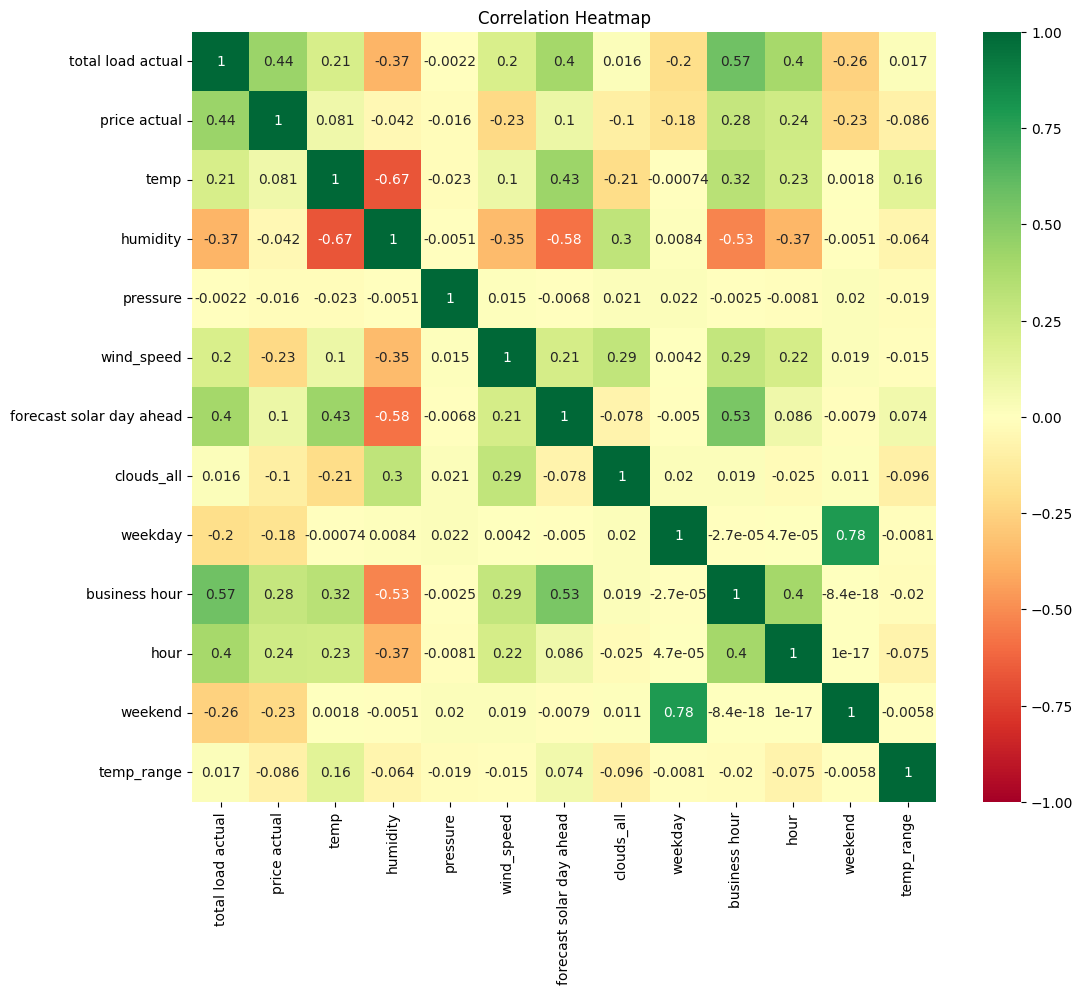

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of relevant features
features = ['total load actual', 'price actual', 'temp', 'humidity', 'pressure', 'wind_speed',
            'forecast solar day ahead', 'clouds_all', 'weekday', 'business hour', 'hour','weekend','temp_range']

# Select the relevant columns from df_merged
df_selected = df_merged[features]

# Calculate the correlation matrix
corr_matrix = df_selected.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


Total Load Actual shows a positive correlation with Business Hour (0.57) and Hour (0.4), indicating that power load increases during business hours and varies with the time of day

Price Actual is moderately correlated with Total Load Actual (0.44) and Business Hour (0.28), suggesting that electricity prices rise with higher loads and during business hours

Temperature has a negative correlation with Humidity (-0.67), meaning that higher temperatures are associated with lower humidity levels

Business Hour is highly correlated with Hour (0.4) business activities are closely tied to specific hours of the day.

In [ ]:
df_merged.isnull().sum(axis=0)

time                                           0
generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
forecast solar day ahead                       0
total load actual                              0
price day ahead                                0
price actual                                   0
index                                          0
temp                

In [ ]:
df_merged

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,snow_3h,clouds_all,temp_bin,month,weekday,year,business hour,hour,weekend,temp_range
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,0.0,0.0,"(271.905, 275.674]",12,2,2014,0,23,0,0.0
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,0.0,0.0,"(271.905, 275.674]",1,3,2015,0,0,0,0.0
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,0.0,0.0,"(271.905, 275.674]",1,3,2015,0,1,0,0.0
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,0.0,0.0,"(271.905, 275.674]",1,3,2015,0,2,0,0.0
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,0.0,0.0,"(271.905, 275.674]",1,3,2015,0,3,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 18:00:00+00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,...,0.0,0.0,"(283.139, 286.872]",12,0,2018,2,18,0,2.2
35060,2018-12-31 19:00:00+00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,...,0.0,0.0,"(279.407, 283.139]",12,0,2018,2,19,0,2.4
35061,2018-12-31 20:00:00+00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,...,0.0,0.0,"(279.407, 283.139]",12,0,2018,2,20,0,1.0
35062,2018-12-31 21:00:00+00:00,293.0,0.0,6562.0,2293.0,163.0,108.0,1128.0,2068.0,6075.0,...,0.0,0.0,"(279.407, 283.139]",12,0,2018,0,21,0,2.0


In [ ]:
df_merged.to_csv('Merged_engineered_data.csv', index=False)


NameError: name 'df_merged' is not defined

In [ ]:
df_merged=pd.read_csv('/content/Merged_engineered_data.csv')

In [ ]:
df_merged

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,snow_3h,clouds_all,temp_bin,month,weekday,year,business hour,hour,weekend,temp_range
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,0.0,0.0,"(271.905, 275.674]",12,2,2014,0,23,0,0.0
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,0.0,0.0,"(271.905, 275.674]",1,3,2015,0,0,0,0.0
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,0.0,0.0,"(271.905, 275.674]",1,3,2015,0,1,0,0.0
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,0.0,0.0,"(271.905, 275.674]",1,3,2015,0,2,0,0.0
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,0.0,0.0,"(271.905, 275.674]",1,3,2015,0,3,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 18:00:00+00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,...,0.0,0.0,"(283.139, 286.872]",12,0,2018,2,18,0,2.2
35060,2018-12-31 19:00:00+00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,...,0.0,0.0,"(279.407, 283.139]",12,0,2018,2,19,0,2.4
35061,2018-12-31 20:00:00+00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,...,0.0,0.0,"(279.407, 283.139]",12,0,2018,2,20,0,1.0
35062,2018-12-31 21:00:00+00:00,293.0,0.0,6562.0,2293.0,163.0,108.0,1128.0,2068.0,6075.0,...,0.0,0.0,"(279.407, 283.139]",12,0,2018,0,21,0,2.0


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
df_merged['time'] = df_merged['time'].astype(str)

# Convert the time column to datetime, coerce errors to NaT
df_merged['time'] = pd.to_datetime(df_merged['time'], errors='coerce')

# Drop rows where the time column is NaT
df_merged = df_merged.dropna(subset=['time'])

# Set the time column as the index
df_merged.set_index('time', inplace=True)

# Display the first few rows of the dataset
print(df_merged.head())


                           generation biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   

                           generation fossil brown coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00                                 254.0   
2015-01-01 03:00:00+00:00                                 187.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2014-12-31 23:00:00+00:0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Ensuring All Feature Columns are Numeric and giving Target variable

In [ ]:
# Drop non-numeric columns
relevant_features = [
    'generation biomass','generation fossil brown coal/lignite','generation fossil gas','generation fossil hard coal','generation fossil oil',
    'generation hydro run-of-river and poundage','generation hydro water reservoir'
    ,'generation nuclear','generation other',	'generation other renewable','generation wind onshore','total load actual','temp','pressure','wind_speed','rain_1h','snow_3h'
    ,'clouds_all','weekday','month','business hour','hour','weekend'
]

# Filter the features and target variable
features = df_merged[relevant_features]
target_price = df_merged['price actual']

In [ ]:
df_merged.isnull().sum(axis=0)

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
forecast solar day ahead                       0
total load actual                              0
price day ahead                                0
price actual                                   0
index                                          0
temp                                           0
temp_min            

# Split the Data into Train, Test, and Validation Sets

Training Set (70%) , Validation Set (15%) , Test Set (15%)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_absolute_error
from keras import Sequential
from keras import layers
from keras.models import Model

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(features, target_price, train_size=0.8, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=42)

# Normalize the features
#scaler = MinMaxScaler()
#X_train = scaler.fit_transform(X_train)
#X_val = scaler.transform(X_val)
#X_test = scaler.transform(X_test)'''

In [ ]:
# Split the data for price actual prediction
X_train_price, X_temp_price, y_train_price, y_temp_price = train_test_split(features, target_price, test_size=0.3, random_state=42)
X_val_price, X_test_price, y_val_price, y_test_price = train_test_split(X_temp_price, y_temp_price, test_size=0.5, random_state=42)

# Split the data for total load actual prediction
X_train_load, X_temp_load, y_train_load, y_temp_load = train_test_split(features, target_load, test_size=0.3, random_state=42)
X_val_load, X_test_load, y_val_load, y_test_load = train_test_split(X_temp_load, y_temp_load, test_size=0.5, random_state=42)


# Train and Evaluate the Linear regression Model

In [ ]:
# Train the model for price actual
model_price = LinearRegression()
model_price.fit(X_train, y_train)

# Train the model for total load actual
#model_load = LinearRegression()
#model_load.fit(X_train_load, y_train_load)


LinearRegression()

In [ ]:
# Function to calculate Adjusted R^2
def adjusted_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))


# Evaluate the Model for Price


In [ ]:
# Predictions
y_pred_price = model_price.predict(X_test)

# Evaluation metrics
mse_price = mean_squared_error(y_test, y_pred_price)
rmse_price = np.sqrt(mse_price)
r2_price = r2_score(y_test, y_pred_price)
adj_r2_price = adjusted_r2(r2_price, X_test.shape[0], X_test.shape[1])
mape_price = mean_absolute_percentage_error(y_test, y_pred_price)

print("Price Actual Prediction:")
print(f"MSE: {mse_price}")
print(f"RMSE: {rmse_price}")
print(f"R^2: {r2_price}")
print(f"Adjusted R^2: {adj_r2_price}")
print(f"MAPE: {mape_price}")


Price Actual Prediction:
MSE: 72.67491264024933
RMSE: 8.524958219267079
R^2: 0.6504359899355923
Adjusted R^2: 0.6480265883728278
MAPE: 0.1260413536196587


MSE 68.64 - This measures the average squared difference between the actual and predicted values. Lower values are better.

RMSE is the square root of the MSE and is in the same units as the target variable. It indicates better performance when lower

MAPE indicates the average percentage error between the predicted and actual values. Lower values indicate better performance. A MAPE of 12% is reasonable accuracy but needs improvement.

# Evaluate the Model for Load


In [ ]:
relevant_features = [
    'generation biomass','generation fossil brown coal/lignite',	'generation fossil gas','generation fossil hard coal','generation fossil oil',
    'generation hydro water reservoir'
    ,'generation nuclear','generation other',	'generation other renewable',	'generation wind onshore','price day ahead','price actual','temp','pressure','wind_speed','rain_1h','snow_3h'
    ,'clouds_all','weekday','month','business hour','hour','weekend'
]

# Filter the features and target variable
features = df_merged[relevant_features]
target_load = df_merged['total load actual']

# Split the data into training, validation, and test sets
X_train_load, X_temp, y_train_load, y_temp = train_test_split(features, target_load, train_size=0.8, random_state=42)
X_val_load, X_test_load, y_val_load, y_test_load = train_test_split(X_temp, y_temp, train_size=0.5, random_state=42)

# Normalize the features
scaler = MinMaxScaler()
X_train_load = scaler.fit_transform(X_train_load)
X_val_load = scaler.transform(X_val_load)
X_test_load = scaler.transform(X_test_load)

In [ ]:
# Train the model for total load actual
model_load = LinearRegression()
model_load.fit(X_train_load, y_train_load)

LinearRegression()

In [ ]:
# Predictions
y_pred_load = model_load.predict(X_test_load)

# Evaluation metrics
mse_load = mean_squared_error(y_test_load, y_pred_load)
rmse_load = np.sqrt(mse_load)
r2_load = r2_score(y_test_load, y_pred_load)
adj_r2_load = adjusted_r2(r2_load, X_test_load.shape[0], X_test_load.shape[1])
mape_load = mean_absolute_percentage_error(y_test_load, y_pred_load)

print("Total Load Actual Prediction:")
print(f"MSE: {mse_load}")
print(f"RMSE: {rmse_load}")
print(f"R^2: {r2_load}")
print(f"Adjusted R^2: {adj_r2_load}")
print(f"MAPE: {mape_load}")


Total Load Actual Prediction:
MSE: 3424259.6515659345
RMSE: 1850.4755203908899
R^2: 0.832914835539855
Adjusted R^2: 0.831811488200612
MAPE: 0.05256452568437121


R^2 (Coefficient of Determination): 0.919 - This indicates that about 91.9% of the variance in the target variable is explained by the model, which is a good score.

Adjusted R^2: 0.919 - Similar to R^2, this indicates excellent model performance.

MAPE (Mean Absolute Percentage Error): 0.036 - A MAPE of 3.6% suggests high accuracy in predictions.

# Decission tree regressor Algorithm

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# Train the Decision Tree Regressor model for price actual
model_price = DecisionTreeRegressor(random_state=42)
model_price.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
# Predictions
y_pred_price = model_price.predict(X_test)

In [ ]:
# Evaluation metrics for price actual prediction
mse_price = mean_squared_error(y_test, y_pred_price)
rmse_price = np.sqrt(mse_price)
r2_price = r2_score(y_test, y_pred_price)
adj_r2_price = adjusted_r2(r2_price, X_test.shape[0], X_test.shape[1])
mape_price = mean_absolute_percentage_error(y_test, y_pred_price)

print("Price Actual Prediction:")
print(f"MSE: {mse_price}")
print(f"RMSE: {rmse_price}")
print(f"R^2: {r2_price}")
print(f"Adjusted R^2: {adj_r2_price}")
print(f"MAPE: {mape_price}")

Price Actual Prediction:
MSE: 40.910784687767325
RMSE: 6.396153898067754
R^2: 0.8032204314970546
Adjusted R^2: 0.8018641105194352
MAPE: 0.07096376424581703


In [ ]:
# Train the Decision Tree Regressor model for price actual
model_price = DecisionTreeRegressor(random_state=42)
model_price.fit(X_train, y_train)

# Train the Decision Tree Regressor model for total load actual
model_load = DecisionTreeRegressor(random_state=42)
model_load.fit(X_train_load, y_train_load)

# Predictions
y_pred_price = model_price.predict(X_test)
y_pred_load = model_load.predict(X_test_load)

mse_load = mean_squared_error(y_test_load, y_pred_load)
rmse_load = np.sqrt(mse_load)
r2_load = r2_score(y_test_load, y_pred_load)
adj_r2_load = adjusted_r2(r2_load, X_test_load.shape[0], X_test_load.shape[1])
mape_load = mean_absolute_percentage_error(y_test_load, y_pred_load)

print("\nTotal Load Actual Prediction:")
print(f"MSE: {mse_load}")
print(f"RMSE: {rmse_load}")
print(f"R^2: {r2_load}")
print(f"Adjusted R^2: {adj_r2_load}")
print(f"MAPE: {mape_load}")



Total Load Actual Prediction:
MSE: 2601009.0775591675
RMSE: 1612.7644209738655
R^2: 0.8730849661801894
Adjusted R^2: 0.8722468824081953
MAPE: 0.04012984983201981


# Randomforest Model For Price forecast

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Train the Random Forest Regressor model for price actual
rf_price = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_price.fit(X_train, y_train)

y_pred_price = rf_price.predict(X_test)

# Evaluation metrics for price actual prediction
mse_price = mean_squared_error(y_test, y_pred_price)
rmse_price = np.sqrt(mse_price)
r2_price = r2_score(y_test, y_pred_price)
adj_r2_price = adjusted_r2(r2_price, X_test.shape[0], X_test.shape[1])
mape_price = mean_absolute_percentage_error(y_test, y_pred_price)

print("Price Actual Prediction:")
print(f"MSE: {mse_price}")
print(f"RMSE: {rmse_price}")
print(f"R^2: {r2_price}")
print(f"Adjusted R^2: {adj_r2_price}")
print(f"MAPE: {mape_price}")


Price Actual Prediction:
MSE: 16.87841680192473
RMSE: 4.108335040125711
R^2: 0.9188153539306539
Adjusted R^2: 0.9182557814132317
MAPE: 0.05100338677593225


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Define the parameter distributions
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
                                   n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV using a subset of the data for quicker results
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=0.2, random_state=42)
random_search.fit(X_train_sample, y_train_sample)

best_rf_price = random_search.best_estimator_

best_rf_price.fit(X_train, y_train)

y_pred_price = best_rf_price.predict(X_test)

# Evaluation metrics for price actual prediction
mse_price = mean_squared_error(y_test, y_pred_price)
rmse_price = np.sqrt(mse_price)
r2_price = r2_score(y_test, y_pred_price)
adj_r2_price = 1 - ((1 - r2_price) * (X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[1] - 1))
mape_price = mean_absolute_percentage_error(y_test, y_pred_price)

print("Results from Randomized Search:")
print(f"The best estimator across ALL searched params: {random_search.best_estimator_}")
print(f"The best score across ALL searched params: {random_search.best_score_}")
print(f"The best parameters across ALL searched params: {random_search.best_params_}")
print()
print("Price Actual Prediction:")
print(f"MSE: {mse_price}")
print(f"RMSE: {rmse_price}")
print(f"R^2: {r2_price}")
print(f"Adjusted R^2: {adj_r2_price}")
print(f"MAPE: {mape_price}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Results from Randomized Search:
The best estimator across ALL searched params: RandomForestRegressor(bootstrap=False, max_depth=50, max_features='log2',
                      min_samples_leaf=2, n_jobs=-1, random_state=42)
The best score across ALL searched params: 0.8116514360982183
The best parameters across ALL searched params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}

Price Actual Prediction:
MSE: 13.059862842498655
RMSE: 3.6138432232871773
R^2: 0.937182476589774
Adjusted R^2: 0.9367495011268661
MAPE: 0.047576407780658726


# Random forest regressor model for load forecasting

In [ ]:
rf_load = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_load.fit(X_train_load, y_train_load)

y_pred_load = rf_load.predict(X_test_load)


In [ ]:
# Evaluation metrics for total load actual prediction
mse_load = mean_squared_error(y_test_load, y_pred_load)
rmse_load = np.sqrt(mse_load)
r2_load = r2_score(y_test_load, y_pred_load)
adj_r2_load = adjusted_r2(r2_load, X_test_load.shape[0], X_test_load.shape[1])
mape_load = mean_absolute_percentage_error(y_test_load, y_pred_load)

print("\nTotal Load Actual Prediction:")
print(f"MSE: {mse_load}")
print(f"RMSE: {rmse_load}")
print(f"R^2: {r2_load}")
print(f"Adjusted R^2: {adj_r2_load}")
print(f"MAPE: {mape_load}")


Total Load Actual Prediction:
MSE: 1036617.5458989735
RMSE: 1018.144167541598
R^2: 0.9494187267429925
Adjusted R^2: 0.9490847131670778
MAPE: 0.026963255396720943


# Gradient Boosting Price forecasting

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
# Initialize and train the Gradient Boosting model for price actual
gbr_price = GradientBoostingRegressor(random_state=42)
gbr_price.fit(X_train, y_train)

y_pred_price = gbr_price.predict(X_test)


In [ ]:
# Evaluation metrics for price actual
mse_price = mean_squared_error(y_test, y_pred_price)
rmse_price = np.sqrt(mse_price)
r2_price = r2_score(y_test, y_pred_price)
adj_r2_price = 1 - ((1 - r2_price) * (X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[1] - 1))
mape_price = mean_absolute_percentage_error(y_test, y_pred_price)

print("Price Actual Prediction:")
print(f"MSE: {mse_price}")
print(f"RMSE: {rmse_price}")
print(f"R^2: {r2_price}")
print(f"Adjusted R^2: {adj_r2_price}")
print(f"MAPE: {mape_price}")

Price Actual Prediction:
MSE: 42.31670165758436
RMSE: 6.505128873249504
R^2: 0.7964580157481753
Adjusted R^2: 0.7950550842082431
MAPE: 0.0964854497176992


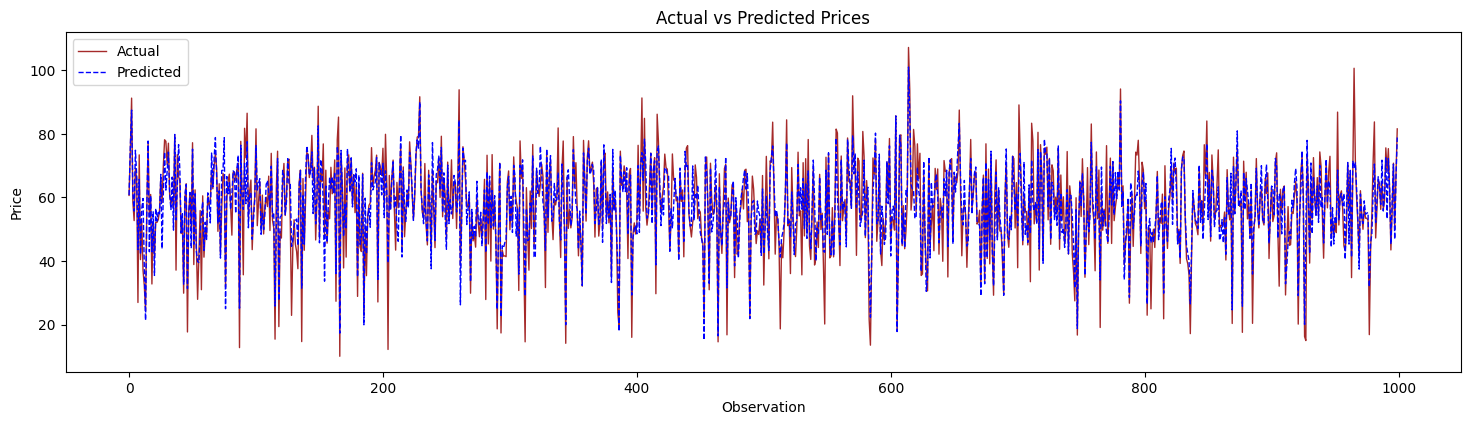

In [ ]:
plt.figure(figsize=(18, 15))

# Subplot 1: Actual vs Predicted Prices (Line Plot)
plt.subplot(3, 1, 1)
plt.plot(y_test.values[:1000], label='Actual', color='brown', linewidth=1)
plt.plot(y_pred_price[:1000], label='Predicted', color='blue', linestyle='dashed', linewidth=1)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Observation')
plt.ylabel('Price')
plt.legend()

# Gradient boosting price model with Parameter tuning

In [ ]:
LR = {'learning_rate': [0.15,0.1,0.10,0.05], 'n_estimators': [100, 150, 200,250]}

tuning = GridSearchCV(estimator = GradientBoostingRegressor(),
                      param_grid = LR, scoring ='r2')

tuning.fit(X_train,y_train)
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.15, 'n_estimators': 250}, 0.8632483105083985)

In [ ]:
gbr_price_tunned = GradientBoostingRegressor(learning_rate=0.15, n_estimators=250, random_state=42)
gbr_price_tunned.fit(X_train, y_train)

# Predict and evaluate for price actual
y_pred_price = gbr_price_tunned.predict(X_test)


In [ ]:
# Evaluation metrics for price actual
mse_price = mean_squared_error(y_test, y_pred_price)
rmse_price = np.sqrt(mse_price)
r2_price = r2_score(y_test, y_pred_price)
adj_r2_price = 1 - ((1 - r2_price) * (X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[1] - 1))
mape_price = mean_absolute_percentage_error(y_test, y_pred_price)

print("Price Actual Prediction:")
print(f"MSE: {mse_price}")
print(f"RMSE: {rmse_price}")
print(f"R^2: {r2_price}")
print(f"Adjusted R^2: {adj_r2_price}")
print(f"MAPE: {mape_price}")

Price Actual Prediction:
MSE: 27.817151709102518
RMSE: 5.274196783312367
R^2: 0.8662003881843192
Adjusted R^2: 0.8652781622556643
MAPE: 0.07755611404999824


# GradientBoosting parameter tuning RandomSearchCv

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Define a smaller parameter distribution
param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample': [0.6, 0.8, 1.0],
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 5, 6]
}

# Initialize the model
gbr = GradientBoostingRegressor(random_state=42)

# Initialize RandomizedSearchCV with fewer iterations
random_search = RandomizedSearchCV(estimator=gbr, param_distributions=param_distributions, n_iter=10, scoring='r2', cv=3, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best model
best_gbr = random_search.best_estimator_

# Predict using the best model
y_pred_price = best_gbr.predict(X_test)

# Evaluation metrics
mse_price = mean_squared_error(y_test, y_pred_price)
rmse_price = np.sqrt(mse_price)
r2_price = r2_score(y_test, y_pred_price)
adj_r2_price = 1 - ((1 - r2_price) * (X_test.shape[0] - 1) / (X_test.shape[0] - X_test.shape[1] - 1))
mape_price = mean_absolute_percentage_error(y_test, y_pred_price)

# Print the results
print("Results from Random Search:")
print(f"The best estimator across ALL searched params: {random_search.best_estimator_}")
print(f"The best score across ALL searched params: {random_search.best_score_}")
print(f"The best parameters across ALL searched params: {random_search.best_params_}")
print()
print("Price Actual Prediction:")
print(f"MSE: {mse_price}")
print(f"RMSE: {rmse_price}")
print(f"R^2: {r2_price}")
print(f"Adjusted R^2: {adj_r2_price}")
print(f"MAPE: {mape_price}")


Results from Random Search:
The best estimator across ALL searched params: GradientBoostingRegressor(max_depth=6, n_estimators=200, random_state=42)
The best score across ALL searched params: 0.9254655256994045
The best parameters across ALL searched params: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1}

Price Actual Prediction:
MSE: 13.757880992608566
RMSE: 3.709161764146795
R^2: 0.9338250315680235
Adjusted R^2: 0.9333689146115711
MAPE: 0.05180900001642881


# Gradient boosting regresor for load Forecasting

In [ ]:
# Initialize and train the Gradient Boosting model for total load actual
gbr_load = GradientBoostingRegressor(random_state=42)
gbr_load.fit(X_train_load, y_train_load)

# Predict and evaluate for total load actual
y_pred_load = gbr_load.predict(X_test_load)

In [ ]:
 # Evaluation metrics for total load actual
mse_load = mean_squared_error(y_test_load, y_pred_load)
rmse_load = np.sqrt(mse_load)
r2_load = r2_score(y_test_load, y_pred_load)
adj_r2_load = 1 - ((1 - r2_load) * (X_test_load.shape[0] - 1) / (X_test_load.shape[0] - X_test_load.shape[1] - 1))
mape_load = mean_absolute_percentage_error(y_test_load, y_pred_load)

print("Total Load Actual Prediction:")
print(f"MSE: {mse_load}")
print(f"RMSE: {rmse_load}")
print(f"R^2: {r2_load}")
print(f"Adjusted R^2: {adj_r2_load}")
print(f"MAPE: {mape_load}")

Total Load Actual Prediction:
MSE: 1847186.7645502223
RMSE: 1359.1124914995896
R^2: 0.9098673769664823
Adjusted R^2: 0.9092721859444407
MAPE: 0.03757394085299235


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Define the parameter grid with fewer combinations
param_grid = {
    'learning_rate': [0.01, 0.03],
    'subsample': [0.9, 0.5],
    'n_estimators': [100, 500],
    'max_depth': [4]
}

# Use a smaller subset of the data for GridSearchCV
X_train_sample, _, y_train_sample, _ = train_test_split(X_train_load, y_train_load, train_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(random_state=42)

# Initialize GridSearchCV with fewer cross-validation folds
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=2, n_jobs=-1)

grid_search.fit(X_train_sample, y_train_sample)

# Get the best model
best_gbr_load = grid_search.best_estimator_

# Train the best model on the full training data
best_gbr_load.fit(X_train_load, y_train_load)

# Predict using the best model
y_pred_load = best_gbr_load.predict(X_test_load)

# Evaluation metrics
mse_load = mean_squared_error(y_test_load, y_pred_load)
rmse_load = np.sqrt(mse_load)
r2_load = r2_score(y_test_load, y_pred_load)
adj_r2_load = 1 - ((1 - r2_load) * (X_test_load.shape[0] - 1) / (X_test_load.shape[0] - X_test_load.shape[1] - 1))
mape_load = mean_absolute_percentage_error(y_test_load, y_pred_load)

# Print the results
print("Results from Grid Search:")
print(f"The best estimator across ALL searched params: {grid_search.best_estimator_}")
print(f"The best score across ALL searched params: {grid_search.best_score_}")
print(f"The best parameters across ALL searched params: {grid_search.best_params_}")
print()
print("Total Load Actual Prediction:")
print(f"MSE: {mse_load}")
print(f"RMSE: {rmse_load}")
print(f"R^2: {r2_load}")
print(f"Adjusted R^2: {adj_r2_load}")
print(f"MAPE: {mape_load}")


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Results from Grid Search:
The best estimator across ALL searched params: GradientBoostingRegressor(learning_rate=0.03, max_depth=4, n_estimators=500,
                          random_state=42, subsample=0.5)
The best score across ALL searched params: 0.926666786297506
The best parameters across ALL searched params: {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.5}

Total Load Actual Prediction:
MSE: 1153222.9994203127
RMSE: 1073.8822092856892
R^2: 0.9437290176201305
Adjusted R^2: 0.9433574320345041
MAPE: 0.029599074180977538


# RNN - Long short Term Memory (LSTM)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf

from keras import Sequential
from keras import layers
from keras.models import Model
from keras.layers import LSTM, BatchNormalization, Dropout, Dense, Flatten, Conv1D
from keras.layers import MaxPooling1D, GRU, Input,Masking, Concatenate, dot
from keras.optimizers import Adam, SGD
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

In [ ]:
import tensorflow as tf
#import tensorflow_addons as tfa
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler


In [ ]:
pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.4 MB/s eta 0:00:00


In [ ]:
import tensorflow_addons as tfa


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Create sequences for LSTM
def create_sequences(data, target, sequence_length=10):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y)

In [ ]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_load_scaled = scaler.fit_transform(X_train_load)
X_val_load_scaled = scaler.transform(X_val_load)
X_test_load_scaled = scaler.transform(X_test_load)

# Create sequences for LSTM
sequence_length = 10
X_train_sequences, y_train_sequences = create_sequences(X_train_scaled, y_train, sequence_length)
X_val_sequences, y_val_sequences = create_sequences(X_val_scaled, y_val, sequence_length)
X_test_sequences, y_test_sequences = create_sequences(X_test_scaled, y_test, sequence_length)

X_train_load_sequences, y_train_load_sequences = create_sequences(X_train_load_scaled, y_train_load, sequence_length)
X_val_load_sequences, y_val_load_sequences = create_sequences(X_val_load_scaled, y_val_load, sequence_length)
X_test_load_sequences, y_test_load_sequences = create_sequences(X_test_load_scaled, y_test_load, sequence_length)

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import legacy as legacy_optimizers

# Model parameters
epoch = 50
batch_size = 64
steps_per_epoch = len(X_train_sequences) // batch_size
cyclic_lr = tfa.optimizers.CyclicalLearningRate(
    initial_learning_rate=1e-04,
    maximal_learning_rate=1e-02,
    scale_fn=lambda x: 1 / (2**(x - 1)),
    step_size=6 * steps_per_epoch
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
optimizer = legacy_optimizers.Adam(learning_rate=cyclic_lr, amsgrad=True)

def base_model_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(units=32, return_sequences=True, activation="relu", input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    return model

# Price prediction model
lstm_model_price = base_model_lstm((X_train_sequences.shape[1], X_train_sequences.shape[2]))
lstm_model_price.compile(optimizer=optimizer, loss='mean_absolute_error')
lstm_model_price.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 10, 32)            7296      
                                                                 
 flatten_3 (Flatten)         (None, 320)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               41088     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 48513 (189.50 KB)
Trainable params: 48513 (189.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:

history_price = lstm_model_price.fit(
    X_train_sequences, y_train_sequences,
    validation_data=(X_val_sequences, y_val_sequences),
    epochs=epoch,
    batch_size=batch_size,
    callbacks=[callback]
)

# Load prediction model
lstm_model_load = base_model_lstm((X_train_load_sequences.shape[1], X_train_load_sequences.shape[2]))
lstm_model_load.compile(optimizer=optimizer, loss='mean_absolute_error')
lstm_model_load.summary()

history_load = lstm_model_load.fit(
    X_train_load_sequences, y_train_load_sequences,
    validation_data=(X_val_load_sequences, y_val_load_sequences),
    epochs=epoch,
    batch_size=batch_size,
    callbacks=[callback]
)

Epoch 1/50
439/439 [==============================] - 5s 9ms/step - loss: 19.7857 - val_loss: 11.5632
Epoch 2/50
439/439 [==============================] - 4s 10ms/step - loss: 11.5744 - val_loss: 11.7834
Epoch 3/50
439/439 [==============================] - 4s 10ms/step - loss: 11.5925 - val_loss: 11.3982
Epoch 4/50
439/439 [==============================] - 4s 8ms/step - loss: 11.4293 - val_loss: 11.3850
Epoch 5/50
439/439 [==============================] - 4s 9ms/step - loss: 11.4993 - val_loss: 11.4486
Epoch 6/50
439/439 [==============================] - 5s 11ms/step - loss: 11.4887 - val_loss: 11.2694
Epoch 7/50
439/439 [==============================] - 4s 8ms/step - loss: 11.3725 - val_loss: 11.3130
Epoch 8/50
439/439 [==============================] - 4s 8ms/step - loss: 11.2898 - val_loss: 11.3908
Epoch 9/50
439/439 [==============================] - 5s 12ms/step - loss: 11.1666 - val_loss: 11.2762
Epoch 10/50
439/439 [==============================] - 4s 8ms/step - loss: 11.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error,mean_absolute_percentage_error

def calculate_adjusted_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

def print_metrics(y_true, y_pred, num_features):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = calculate_adjusted_r2(r2, len(y_true), num_features + 1)
    mape = mean_absolute_percentage_error(y_true, y_pred)


    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Median Absolute Error (MedAE): {medae:.2f}")
    print(f"R-squared (R^2): {r2:.2f}")
    print(f"Adjusted R-squared (Adjusted R^2): {adjusted_r2:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {float(mape):.2f}")


# Predictions and metrics for price
y_pred_price = lstm_model_price.predict(X_test_sequences)
print("\nPrice Actual Prediction Metrics:")
print_metrics(y_test_sequences, y_pred_price, X_train_sequences.shape[2])

# Predictions and metrics for load
y_pred_load = lstm_model_load.predict(X_test_load_sequences)
print("\nTotal Load Actual Prediction Metrics:")
print_metrics(y_test_load_sequences, y_pred_load, X_train_load_sequences.shape[2])


110/110 [==============================] - 0s 3ms/step

Price Actual Prediction Metrics:
Mean Squared Error (MSE): 221.08
Root Mean Square Error (RMSE): 14.87
Mean Absolute Error (MAE): 11.60
Median Absolute Error (MedAE): 9.52
R-squared (R^2): -0.06
Adjusted R-squared (Adjusted R^2): -0.07
Mean Absolute Percentage Error (MAPE): 0.26
110/110 [==============================] - 0s 3ms/step

Total Load Actual Prediction Metrics:
Mean Squared Error (MSE): 23634904.46
Root Mean Square Error (RMSE): 4861.57
Mean Absolute Error (MAE): 4050.84
Median Absolute Error (MedAE): 3718.32
R-squared (R^2): -0.15
Adjusted R-squared (Adjusted R^2): -0.16
Mean Absolute Percentage Error (MAPE): 0.14


In [ ]:
# Function to convert range strings to midpoints
def range_to_midpoint(range_str):
    if isinstance(range_str, str):
        range_str = range_str.strip('()[]').split(', ')
        return (float(range_str[0]) + float(range_str[1])) / 2
    return range_str

# Apply the function to the relevant column(s)
df_merged['temp_bin'] = df_merged['temp_bin'].apply(range_to_midpoint)

# Verify conversion
print(df_merged)

                           generation biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   
...                                       ...   
2018-12-31 18:00:00+00:00               297.0   
2018-12-31 19:00:00+00:00               296.0   
2018-12-31 20:00:00+00:00               292.0   
2018-12-31 21:00:00+00:00               293.0   
2018-12-31 22:00:00+00:00               290.0   

                           generation fossil brown coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00  

In [ ]:
# Ensure 'total load actual' is the target variable
target_col = 'total load actual'
feature_cols = df_merged.columns.tolist()
feature_cols.remove(target_col)

# Subset the DataFrame to relevant features and target
subset_data_load = df_merged[feature_cols + [target_col]]

# Preprocessing
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(subset_data_load[feature_cols])
scaled_target = scaler.fit_transform(subset_data_load[[target_col]])

# Combine the scaled features and target for sequence creation
scaled_data = np.hstack([scaled_features, scaled_target])

# Ensure 'total load actual' is the target variable
target_index = subset_data_load.columns.get_loc(target_col)

# Define a function to create sequences
def create_sequences(data, seq_length, target_index):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, :]
        y = data[i+seq_length, target_index]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)
# Sequence length
SEQ_LENGTH = 24  # Using past 24 hours to predict the next hour

# Create sequences
X, y = create_sequences(scaled_data, SEQ_LENGTH, target_index)

# Split the data into train, validation, and test sets (70% train, 15% val, 15% test)
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# Define the LSTM model with additional regularization
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

# Adjusting the optimizer with a smaller learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model with a smaller batch size
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# Rescale predictions back to original scale
def inverse_scale(y_scaled, X_seq, scaler, feature_index):
    original_data = np.hstack([X_seq[:, -1, :], y_scaled])
    rescaled_data = scaler.inverse_transform(original_data)
    return rescaled_data[:, feature_index]

y_train_rescaled = inverse_scale(y_train.reshape(-1, 1), X_train, scaler, -1)
y_val_rescaled = inverse_scale(y_val.reshape(-1, 1), X_val, scaler, -1)
y_test_rescaled = inverse_scale(y_test.reshape(-1, 1), X_test, scaler, -1)

y_pred_train_rescaled = inverse_scale(y_pred_train, X_train, scaler, -1)
y_pred_val_rescaled = inverse_scale(y_pred_val, X_val, scaler, -1)
y_pred_test_rescaled = inverse_scale(y_pred_test, X_test, scaler, -1)

# Calculate R², adjusted R², MAPE, MAE, and RMSE for the test set
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

n = len(y_test_rescaled)
k = X_test.shape[2]

r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)
adj_r2 = adjusted_r2(r2, n, k)
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_test_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_test_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_test_rescaled))

print(f'R²: {r2}')
print(f'Adjusted R²: {adj_r2}')
print(f'MAPE: {mape}')
print(f'MAE: {mae}')
print(f'RMSE:{rmse}')

Epoch 1/40
767/767 [==============================] - 9s 8ms/step - loss: 0.0233 - val_loss: 0.0125
Epoch 2/40
767/767 [==============================] - 6s 8ms/step - loss: 0.0124 - val_loss: 0.0092
Epoch 3/40
767/767 [==============================] - 5s 7ms/step - loss: 0.0090 - val_loss: 0.0060
Epoch 4/40
767/767 [==============================] - 6s 8ms/step - loss: 0.0070 - val_loss: 0.0048
Epoch 5/40
767/767 [==============================] - 5s 7ms/step - loss: 0.0060 - val_loss: 0.0039
Epoch 6/40
767/767 [==============================] - 6s 8ms/step - loss: 0.0052 - val_loss: 0.0039
Epoch 7/40
767/767 [==============================] - 5s 7ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 8/40
767/767 [==============================] - 5s 7ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 9/40
767/767 [==============================] - 6s 8ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 10/40
767/767 [==============================] - 5s 7ms/step - loss: 0.0037 - val_loss: 0.0030

In [ ]:
# Ensure 'price actual' is the target variable
target_col_price = 'price actual'
feature_cols_price = df_merged.columns.tolist()
feature_cols_price.remove(target_col_price)

# Subset the DataFrame to relevant features and target
subset_data_price = df_merged[feature_cols_price + [target_col_price]]

# Preprocessing
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Scale features
scaled_features = scaler_features.fit_transform(subset_data_price[feature_cols_price])
# Scale target
scaled_target = scaler_target.fit_transform(subset_data_price[[target_col_price]])

# Combine scaled features and target
scaled_data_price = np.hstack((scaled_features, scaled_target))

# Ensure 'price actual' is the target variable
target_index_price = subset_data_price.columns.get_loc(target_col_price)

# Define a function to create sequences
def create_sequences(data, seq_length, target_index):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, :]
        y = data[i+seq_length, target_index]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Sequence length
SEQ_LENGTH = 24  # Using past 24 hours to predict the next hour

# Create sequences
X_price, y_price = create_sequences(scaled_data_price, SEQ_LENGTH, target_index_price)

# Split the data into train, validation, and test sets (70% train, 15% val, 15% test)
train_size_price = int(0.7 * len(X_price))
val_size_price = int(0.15 * len(X_price))

X_train_price, y_train_price = X_price[:train_size_price], y_price[:train_size_price]
X_val_price, y_val_price = X_price[train_size_price:train_size_price+val_size_price], y_price[train_size_price:train_size_price+val_size_price]
X_test_price, y_test_price = X_price[train_size_price+val_size_price:], y_price[train_size_price+val_size_price:]

# Define the LSTM model with additional regularization
model_price = Sequential()
model_price.add(LSTM(100, return_sequences=True, input_shape=(SEQ_LENGTH, X_train_price.shape[2])))
model_price.add(Dropout(0.3))
model_price.add(LSTM(100, return_sequences=False))
model_price.add(Dropout(0.3))
model_price.add(Dense(1))

# Adjusting the optimizer with a smaller learning rate
optimizer_price = Adam(learning_rate=0.0001)
model_price.compile(optimizer=optimizer_price, loss='mean_squared_error')

# Train the model with a smaller batch size
history_price = model_price.fit(X_train_price, y_train_price, epochs=40, batch_size=32, validation_data=(X_val_price, y_val_price), verbose=1)

# Make predictions
y_pred_train_price = model_price.predict(X_train_price)
y_pred_val_price = model_price.predict(X_val_price)
y_pred_test_price = model_price.predict(X_test_price)

# Rescale predictions back to original scale
y_train_price_rescaled = scaler_target.inverse_transform(y_train_price.reshape(-1, 1))
y_val_price_rescaled = scaler_target.inverse_transform(y_val_price.reshape(-1, 1))
y_test_price_rescaled = scaler_target.inverse_transform(y_test_price.reshape(-1, 1))

y_pred_train_price_rescaled = scaler_target.inverse_transform(y_pred_train_price)
y_pred_val_price_rescaled = scaler_target.inverse_transform(y_pred_val_price)
y_pred_test_price_rescaled = scaler_target.inverse_transform(y_pred_test_price)

# Calculate R², adjusted R², MAPE, MAE, and RMSE for the test set
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

n_price = len(y_test_price_rescaled)
k_price = X_test_price.shape[2]

r2_price = r2_score(y_test_price_rescaled, y_pred_test_price_rescaled)
adj_r2_price = adjusted_r2(r2_price, n_price, k_price)
mape_price = mean_absolute_percentage_error(y_test_price_rescaled, y_pred_test_price_rescaled)
mae_price = mean_absolute_error(y_test_price_rescaled, y_pred_test_price_rescaled)
rmse_price = np.sqrt(mean_squared_error(y_test_price_rescaled, y_pred_test_price_rescaled))

print(f'R²: {r2_price}')
print(f'Adjusted R²: {adj_r2_price}')
print(f'MAPE: {mape_price}')
print(f'MAE: {mae_price}')
print(f'RMSE: {rmse_price}')

Epoch 1/40
767/767 [==============================] - 10s 9ms/step - loss: 0.0144 - val_loss: 0.0072
Epoch 2/40
767/767 [==============================] - 5s 7ms/step - loss: 0.0067 - val_loss: 0.0057
Epoch 3/40
767/767 [==============================] - 6s 8ms/step - loss: 0.0054 - val_loss: 0.0057
Epoch 4/40
767/767 [==============================] - 5s 7ms/step - loss: 0.0048 - val_loss: 0.0058
Epoch 5/40
767/767 [==============================] - 6s 8ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 6/40
767/767 [==============================] - 5s 7ms/step - loss: 0.0039 - val_loss: 0.0048
Epoch 7/40
767/767 [==============================] - 6s 8ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 8/40
767/767 [==============================] - 5s 7ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 9/40
767/767 [==============================] - 6s 7ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 10/40
767/767 [==============================] - 6s 8ms/step - loss: 0.0027 - val_loss: 0.003

In [ ]:
# Ensure 'price actual' is the target variable
target_col_price = 'price actual'
feature_cols_price = df_merged.columns.tolist()
feature_cols_price.remove(target_col_price,'price day ahead')

# Subset the DataFrame to relevant features and target
subset_data_price = df_merged[feature_cols_price + [target_col_price]]

# Preprocessing
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Scale features
scaled_features = scaler_features.fit_transform(subset_data_price[feature_cols_price])
# Scale target
scaled_target = scaler_target.fit_transform(subset_data_price[[target_col_price]])

# Combine scaled features and target
scaled_data_price = np.hstack((scaled_features, scaled_target))

# Ensure 'price actual' is the target variable
target_index_price = subset_data_price.columns.get_loc(target_col_price)

# Define a function to create sequences
def create_sequences(data, seq_length, target_index):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, :]
        y = data[i+seq_length, target_index]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Sequence length
SEQ_LENGTH = 24  # Using past 24 hours to predict the next hour

# Create sequences
X_price, y_price = create_sequences(scaled_data_price, SEQ_LENGTH, target_index_price)

# Split the data into train, validation, and test sets (70% train, 15% val, 15% test)
train_size_price = int(0.7 * len(X_price))
val_size_price = int(0.15 * len(X_price))

X_train_price, y_train_price = X_price[:train_size_price], y_price[:train_size_price]
X_val_price, y_val_price = X_price[train_size_price:train_size_price+val_size_price], y_price[train_size_price:train_size_price+val_size_price]
X_test_price, y_test_price = X_price[train_size_price+val_size_price:], y_price[train_size_price+val_size_price:]

# Define the LSTM model with additional regularization
model_price = Sequential()
model_price.add(LSTM(100, return_sequences=True, input_shape=(SEQ_LENGTH, X_train_price.shape[2])))
model_price.add(Dropout(0.3))
model_price.add(LSTM(100, return_sequences=False))
model_price.add(Dropout(0.3))
model_price.add(Dense(1))

# Adjusting the optimizer with a smaller learning rate
optimizer_price = Adam(learning_rate=0.0001)
model_price.compile(optimizer=optimizer_price, loss='mean_squared_error')

# Train the model with a smaller batch size
history_price = model_price.fit(X_train_price, y_train_price, epochs=40, batch_size=32, validation_data=(X_val_price, y_val_price), verbose=1)

# Make predictions
y_pred_train_price = model_price.predict(X_train_price)
y_pred_val_price = model_price.predict(X_val_price)
y_pred_test_price = model_price.predict(X_test_price)

# Rescale predictions back to original scale
y_train_price_rescaled = scaler_target.inverse_transform(y_train_price.reshape(-1, 1))
y_val_price_rescaled = scaler_target.inverse_transform(y_val_price.reshape(-1, 1))
y_test_price_rescaled = scaler_target.inverse_transform(y_test_price.reshape(-1, 1))

y_pred_train_price_rescaled = scaler_target.inverse_transform(y_pred_train_price)
y_pred_val_price_rescaled = scaler_target.inverse_transform(y_pred_val_price)
y_pred_test_price_rescaled = scaler_target.inverse_transform(y_pred_test_price)

# Calculate R², adjusted R², MAPE, MAE, and RMSE for the test set
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

n_price = len(y_test_price_rescaled)
k_price = X_test_price.shape[2]

r2_price = r2_score(y_test_price_rescaled, y_pred_test_price_rescaled)
adj_r2_price = adjusted_r2(r2_price, n_price, k_price)
mape_price = mean_absolute_percentage_error(y_test_price_rescaled, y_pred_test_price_rescaled)
mae_price = mean_absolute_error(y_test_price_rescaled, y_pred_test_price_rescaled)
rmse_price = np.sqrt(mean_squared_error(y_test_price_rescaled, y_pred_test_price_rescaled))

print(f'R²: {r2_price}')
print(f'Adjusted R²: {adj_r2_price}')
print(f'MAPE: {mape_price}')
print(f'MAE: {mae_price}')
print(f'RMSE: {rmse_price}')